## Data preprocessing

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import lognorm

In [46]:
data_path = "/home/onyx/Documents/Mémoire/memoire/data/sales_train_evaluation.csv"
pkl_path = "/home/onyx/Documents/Mémoire/memoire/data/sales_train_evaluation.pkl"
cal_path = "/home/onyx/Documents/Mémoire/memoire/data/calendar.csv"

REVIEW_TIME = 1
LEAD_TIME = 2

alpha = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.975, 0.99]

In [47]:
def load_data(data_path: str) -> pd.DataFrame:
    """
    Load data from a CSV or pickle file into a pandas DataFrame.
    
    Parameters:
        data_path (str): Path to the data file, can be CSV or pickle.
    
    Returns:
        pd.DataFrame: Loaded DataFrame.
    """
    if data_path.endswith(".csv"):
        # Load the CSV file
        df = pd.read_csv(data_path)
        df.to_pickle(pkl_path)
    elif data_path.endswith(".pkl"):
        # Load the pickle file
        df = pd.read_pickle(pkl_path)
    else:
        raise ValueError("Unsupported file format. Please use .csv or .pkl")

    return df

In [48]:
def scraping_high_zeroes_products(df: pd.DataFrame, n: int) -> pd.DataFrame:
    # Count the number of zeroes in each row
    df['zero_count'] = (df == 0).sum(axis=1)
    
    # Sort the DataFrame by the number of zeroes in ascending order
    df_sorted = df.sort_values(by='zero_count')
    
    # Keep only the top 1000 rows with the least number of zeroes
    df_top_n = df_sorted.head(n)
    
    # Drop the 'zero_count' column as it is no longer needed
    df_top_n = df_top_n.drop(columns=['zero_count'])
    
    return df_top_n

def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess the DataFrame by removing unnecessary columns and converting
    the demand columns to numeric types.
    
    Parameters:
        df (pd.DataFrame): Original DataFrame.
    
    Returns:
        pd.DataFrame: Demand matrix with product 'id' as index and days as columns.
    """
    # Remove unnecessary columns
    df_demand = df.drop(columns=['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])
    # Set 'id' as index
    demand_matrix = df_demand.set_index('id')

    # Load the calendar.csv file
    calendar = pd.read_csv(cal_path)

    # Get the date columns from the calendar dataframe
    date_columns = calendar['date']
    demand_matrix.columns = date_columns[0:demand_matrix.shape[1]]
    
    
    return demand_matrix

def analyse_data(df: pd.DataFrame) -> [pd.Series, pd.Series]:
    means = df.mean(axis=1)
    stds = df.std(axis=1)
    
    return means, stds



# Forecast Computing  

In [49]:
def FC_avg_n_days(demand_matrix: pd.DataFrame, n: int) -> pd.DataFrame:
    """
    Compute the forecast by averaging the last n days for each product.
    
    Parameters:
        demand_matrix (pd.DataFrame): Demand matrix.
    
    Returns:
        pd.DataFrame: Forecast matrix (rounded up).
    """
    forecast_matrix = demand_matrix.T.rolling(window=n).mean().shift(1+REVIEW_TIME+LEAD_TIME).T
    return forecast_matrix

def FC_med_n_days(demand_matrix: pd.DataFrame, n: int) -> pd.DataFrame:
    """
    Compute the forecast by averaging the last n days for each product.
    
    Parameters:
        demand_matrix (pd.DataFrame): Demand matrix.
    
    Returns:
        pd.DataFrame: Forecast matrix (rounded up).
    """
    forecast_matrix = demand_matrix.T.rolling(window=n).median().shift(1+REVIEW_TIME+LEAD_TIME).T
    return forecast_matrix

def FC_avg_n_same_days(demand_matrix: pd.DataFrame, n: int) -> pd.DataFrame:
    """
    Compute the forecast by averaging the same day of the week over the previous 4 weeks for each product.
    
    Parameters:
        demand_matrix (pd.DataFrame): Demand matrix.
    
    Returns:
        pd.DataFrame: Weekly forecast matrix (rounded up).
    """
    demand_np = demand_matrix.to_numpy()
    n_products, n_days = demand_np.shape
    weekly_forecast_np = np.full((n_products, n_days), np.nan)
    
    # For each day of the week (offset from 0 to 6)
    for offset in range(7):
        idx = np.arange(offset, n_days, 7)
        # Need at least 5 weeks to use the previous n weeks
        if len(idx) < n+1:
            continue
        # Create a sliding window view for the previous n weeks
        slices = np.stack([demand_np[:, idx[i: i + len(idx) - n]] for i in range(1,n)], axis=-1)
        rolling_mean = np.mean(slices, axis=-1)
        target_indices = idx[n:]  # Days to forecast
        weekly_forecast_np[:, target_indices] = rolling_mean
        
    weekly_forecast_matrix = pd.DataFrame(
        weekly_forecast_np,
        index=demand_matrix.index,
        columns=demand_matrix.columns
    )
    return weekly_forecast_matrix

def FC_med_n_same_days(demand_matrix: pd.DataFrame, n: int) -> pd.DataFrame:
    """
    Compute the forecast by taking the median of the same day of the week over the previous 4 weeks for each product.
    
    Parameters:
        demand_matrix (pd.DataFrame): Demand matrix.
    
    Returns:
        pd.DataFrame: Weekly forecast matrix (rounded up).
    """
    demand_np = demand_matrix.to_numpy()
    n_products, n_days = demand_np.shape
    weekly_forecast_np = np.full((n_products, n_days), np.nan)
    
    # For each day of the week (offset from 0 to 6)
    for offset in range(7):
        idx = np.arange(offset, n_days, 7)
        # Need at least n+1 weeks to use the previous n weeks
        if len(idx) < n+1:
            continue
        # Create a sliding window view for the previous n weeks
        slices = np.stack([demand_np[:, idx[i: i + len(idx) - n]] for i in range(1,n)], axis=-1)
        rolling_med = np.median(slices, axis=-1)
        target_indices = idx[n:]  # Days to forecast
        weekly_forecast_np[:, target_indices] = rolling_med
        
    weekly_forecast_matrix = pd.DataFrame(
        weekly_forecast_np,
        index=demand_matrix.index,
        columns=demand_matrix.columns
    )
    return weekly_forecast_matrix

# Safety stock

In [50]:
def SS_cst(demand_matrix: pd.DataFrame, forecast_matrix: pd.DataFrame, safety_stock_value: int, R: int) -> pd.DataFrame:
    """
    Create a safety stock matrix with a constant integer value for each product and each day.
    
    Parameters:
        demand_matrix (pd.DataFrame): Demand matrix with product index and days as columns.
        safety_stock_value (int): The safety stock level to assign.
    
    Returns:
        pd.DataFrame: Safety stock matrix with the same shape as demand_matrix, filled with safety_stock_value.
    """
    safety_stock_matrix = pd.DataFrame(
        safety_stock_value,
        index=demand_matrix.index,
        columns=demand_matrix.columns
    )
    return safety_stock_matrix

def SS_on_forecast(demand_matrix: pd.DataFrame, forecast_matrix: pd.DataFrame, safety_stock_factor: int, R: int) -> pd.DataFrame:
    """
    Create a safety stock matrix constituted of the n+3 day of forecast times the safety_stock_factor.

    Parameters:
        demand_matrix (pd.DataFrame): Demand matrix with product index and days as columns.
        safety_stock_factor: The factor to apply to the forecasted demand.

    Returns:
        pd.DataFrame: Safety stock matrix with the same shape as demand_matrix, filled with safety_stock_value.
    """
    safety_stock_matrix = pd.DataFrame(
        safety_stock_factor * forecast_matrix.shift(-R, axis=1).values,
        index=demand_matrix.index,
        columns=demand_matrix.columns
    )
    return safety_stock_matrix


# Up-to-level

In [51]:
def up_to_level_optimal_restock(demand_matrix, forecast_matrix: pd.DataFrame, safety_stock_matrix: pd.DataFrame, X, min_fill_rate, R):
    """
    DEBUG FUNCTION (NOT A POLICY)
    Find the optimal fixed restock level that reaches the minimal fill rate.
    
    Parameters:
        min_fill_rate (float): The minimum fill rate to achieve.
    
    Returns:
        int: The optimal fixed restock level.
    """
    demand = demand_matrix.to_numpy()
    up_to_level = np.ones(demand_matrix.shape)
    _, _, _, _, _, lost_sales = compute_stock(up_to_level, demand)
    fill_rates_per_product = compute_fill_rates_per_product(lost_sales, demand)

    while not (fill_rates_per_product > min_fill_rate).all():
        _, _, _, _, _, lost_sales = compute_stock(up_to_level, demand)
        fill_rates_per_product = compute_fill_rates_per_product(lost_sales, demand)
        goods = np.where(fill_rates_per_product <= min_fill_rate)
        up_to_level[goods] += 1
    
    for i in range(up_to_level.shape[1]):
        if i + R <= up_to_level.shape[1]:
            up_to_level[:, i] = np.sum(up_to_level[:, i:i+R], axis=1)
        else:
            up_to_level[:, i] = np.sum(up_to_level[:, :], axis=1)
    
    return pd.DataFrame(up_to_level, index=demand_matrix.index, columns=demand_matrix.columns)

def compute_fill_rates_per_product(lost_sales, demand):
    """Compute the fill rate for each product
    
    Parameters:
        lost_sales (ndarray): Numpy array of lost sales.
        demand (ndarray): Numpy array of demand.
        
    Returns:
        ndarray: Numpy array of fill rates.
    """
    return 1 - lost_sales.sum(axis=1) / demand.sum(axis=1)
    

In [52]:
def up_to_level_on_forecast(demand_matrix, forecast_matrix: pd.DataFrame, safety_stock_matrix: pd.DataFrame, X, min_fill_rate, R):
    """
    Compute the forecast by summing the demand of the next 3 days for each product.
    
    Parameters:
        demand_matrix (pd.DataFrame): Demand matrix.
    
    Returns:
        pd.DataFrame: Forecast matrix (rounded up).
    """
    up_to_level_matrix = forecast_matrix.T.shift(-R+1).rolling(window=R).sum().T
    up_to_level_matrix += safety_stock_matrix
    
    return np.ceil(up_to_level_matrix)

def up_to_level_fixed_X(demand_matrix, forecast_matrix: pd.DataFrame, safety_stock_matrix: pd.DataFrame, X, min_fill_rate, R):
    ones = np.ones(demand_matrix.shape)
    up_to_level = ones * X
    up_to_level_matrix = pd.DataFrame(up_to_level, index=demand_matrix.index, columns=demand_matrix.columns)
    
    up_to_level = up_to_level_matrix.to_numpy()

    for i in range(up_to_level.shape[1]):
        if i + R <= up_to_level.shape[1]:
            up_to_level[:, i] = np.sum(up_to_level[:, i:i+R], axis=1)
        else:
            up_to_level[:, i] = np.sum(up_to_level[:, :], axis=1)

    up_to_level_matrix = pd.DataFrame(up_to_level, index=demand_matrix.index, columns=demand_matrix.columns)

    return up_to_level_matrix


In [73]:
def up_to_level_normal_demand(
    demand_matrix: pd.DataFrame,
    forecast_matrix,       # non utilisé mais conservé pour pipeline
    safety_stock_matrix,   # idem
    X,                     # idem
    min_fill_rate: float, #CSL
    window_size: int = 14  # taille de la fenêtre glissante
) -> pd.DataFrame:
    """
    Compute the up-to-level based on a normal distribution assumption.
    """
    # 1) Rolling stats (on prend j−window_size à j−1, puis shift pour ne pas prendre j)
    roll_means = demand_matrix.rolling(
        window=window_size, axis=1, min_periods=1
    ).mean().shift(1+REVIEW_TIME+LEAD_TIME, axis=1).fillna(0)
    roll_stds = demand_matrix.rolling(
        window=window_size, axis=1, min_periods=1
    ).std(ddof=0).shift(1+REVIEW_TIME+LEAD_TIME, axis=1).fillna(0)

    # 2) Quantile
    quantiles = pd.DataFrame(
        norm.ppf(min_fill_rate, loc=roll_means.values, scale=roll_stds.values),
        index=demand_matrix.index,
        columns=demand_matrix.columns
    ).clip(lower=0)

    # 3) Somme glissante sur R jours
    n_days = demand_matrix.shape[1]
    up_to = pd.DataFrame(0, index=demand_matrix.index, columns=demand_matrix.columns)
    for j in range(n_days):
        end = min(j + REVIEW_TIME + LEAD_TIME, n_days)
        up_to.iloc[:, j] = quantiles.iloc[:, j:end].sum(axis=1)

    return np.ceil(up_to)

def up_to_level_lognormal_demand(
    demand_matrix: pd.DataFrame,
    forecast_matrix,       # non utilisé mais conservé pour pipeline
    safety_stock_matrix,   # idem
    X,                     # idem
    min_fill_rate: float, #CSL
    R: int,
    window_size: int = 14  # taille de la fenêtre glissante
) -> pd.DataFrame:
    """
    Compute the up-to-level based on a log-normal distribution assumption.
    """
    # 1) Rolling stats (on prend j−window_size à j−1, puis shift)
    roll_means = demand_matrix.rolling(
        window=window_size, axis=1, min_periods=1
    ).mean().shift(1+REVIEW_TIME+LEAD_TIME, axis=1).fillna(0)
    roll_stds = demand_matrix.rolling(
        window=window_size, axis=1, min_periods=1
    ).std(ddof=0).shift(1+REVIEW_TIME+LEAD_TIME, axis=1).fillna(0)
    
    # 2) Convertir roll_means et roll_stds vers les paramètres de la lognormale
    # On suppose que roll_means > 0 pour effectuer le logarithme
    sigma = np.sqrt(np.log(1 + (roll_stds / roll_means)**2))
    mu = np.log(roll_means) - 0.5 * sigma**2

    # 3) Calculer le quantile en utilisant la lognormale : scale = exp(mu), s = sigma 
    quantile_vals = lognorm.ppf(min_fill_rate, s=sigma, scale=np.exp(mu))
    quantiles = pd.DataFrame(quantile_vals, index=demand_matrix.index, columns=demand_matrix.columns).clip(lower=0)
    
    # 4) Somme glissante sur R jours
    n_days = demand_matrix.shape[1]
    up_to = pd.DataFrame(0, index=demand_matrix.index, columns=demand_matrix.columns)
    for j in range(n_days):
        end = min(j + REVIEW_TIME + LEAD_TIME, n_days)
        up_to.iloc[:, j] = quantiles.iloc[:, j:end].sum(axis=1)
    
    return np.ceil(up_to)

# Inventory

In [54]:
def compute_stock(up_to_level, demand, order_rate=REVIEW_TIME):
    """
    Compute various stock management indicators:
      - inventory_begin: stock at the beginning of the day
      - inventory_end: stock at the end of the day
      - T1: stock arriving in 1 day
      - T2: stock arriving in 2 days
      - sales: actual sales
      - lost_sales: unmet demand (lost sales)
    
    Parameters:
        up_to_level (ndarray): Matrix of levels to reach.
        demand (ndarray): Demand matrix.
        order_rate (int): Interval of days between orders.
    
    Returns:
        tuple of pd.DataFrame: DataFrames for inventory_begin, inventory_end, T1, T2, sales, and lost_sales.
    """

    """ # Conversion vers arrays
    demand = demand_matrix.to_numpy()
    up_to_level = up_to_level_matrix.to_numpy()
    # Ensure no NaN values in the matrices """
    np.nan_to_num(up_to_level, copy=False)

    n_products, n_days = demand.shape

    # Initialisation des arrays
    inventory_begin = np.zeros_like(demand)
    inventory_end = np.zeros_like(demand)
    T1 = np.zeros_like(demand)
    T2 = np.zeros_like(demand)
    sales = np.zeros_like(demand)
    lost_sales = np.zeros_like(demand)
    T2[:, 0] = up_to_level[:, 0] - inventory_begin[:, 0]
    inventory_end[:, 0] = np.maximum(inventory_begin[:, 0] - demand[:, 0], 0)
    sales[:, 0] = inventory_begin[:, 0] - inventory_end[:, 0]
    lost_sales[:, 0] = np.maximum(demand[:, 0] - sales[:, 0], 0)

    # Boucle vectorisée jour par jour
    for day in range(1, n_days):
        T1[:, day] = T2[:, day - 1]
        inventory_begin[:, day] = inventory_end[:, day - 1] + T1[:, day - 1]
        inventory_end[:, day] = np.maximum(inventory_begin[:, day] - demand[:, day], 0)

        if(day%order_rate == 0):
            T2[:, day] = np.nan_to_num(np.maximum(up_to_level[:, day] - inventory_end[:, day] - T1[:, day], 0))
        sales[:, day] = inventory_begin[:, day] - inventory_end[:, day]
        lost_sales[:, day] = np.maximum(demand[:, day] - sales[:, day], 0)

    return inventory_begin, inventory_end, T1, T2, sales, lost_sales

#inventory_begin, inventory_end, _, _, _, lost_sales = compute_stock(up_to_level_matrix.to_numpy(), demand_matrix.to_numpy())

def compute_stock_Q_s(Q, s, demand, order_rate=REVIEW_TIME):
    """
    Compute stock management indicators for a (Q,s) policy.
    
    Returns:
        tuple of pd.DataFrame: DataFrames for inventory_begin, inventory_end, T1, T2, sales, and lost_sales.
    """

    np.nan_to_num(Q, copy=False)

    _, n_days = demand.shape

    # Arrays init
    inventory_begin = np.zeros_like(demand)
    inventory_end = np.zeros_like(demand)
    T1 = np.zeros_like(demand)
    T2 = np.zeros_like(demand)
    sales = np.zeros_like(demand)
    lost_sales = np.zeros_like(demand)

    #Day 0 init
    inventory_begin[:, 0] = 5
    T1[:, 0] = 0
    # Si le stock initial est inférieur ou égal à s, on commande Q[:,0] unités
    reorder_mask = inventory_begin[:, 0] <= s[:, 0]
    T2[:, 0] = np.where(reorder_mask, Q[:, 0], 0)
    inventory_end[:, 0] = np.maximum(inventory_begin[:, 0] - demand[:, 0], 0)
    sales[:, 0] = inventory_begin[:, 0] - inventory_end[:, 0]
    lost_sales[:, 0] = np.maximum(demand[:, 0] - sales[:, 0], 0)

    for day in range(1, n_days):
        T1[:, day] = T2[:, day - 1]
        inventory_begin[:, day] = inventory_end[:, day - 1] + T1[:, day - 1]
        inventory_end[:, day] = np.maximum(inventory_begin[:, day] - demand[:, day], 0)

        # Si le stock après vente est inférieur ou égal à s[:,day], on commande Q[:,day] unités
        reorder_mask = inventory_end[:, day] <= s[:, day]
        if(day%order_rate == 0):
            T2[:, day] = np.where(reorder_mask, Q[:, day], 0)

        sales[:, day] = inventory_begin[:, day] - inventory_end[:, day]
        lost_sales[:, day] = np.maximum(demand[:, day] - sales[:, day], 0)

    return inventory_begin, inventory_end, T1, T2, sales, lost_sales


# Performance metrics

In [55]:
def compute_results(demand, lost_sales, inventory_begin, inventory_end, n_days):
    """
    Compute overall stock management metrics:
      - Fill rate
      - Average inventory
      - Ratio of days with perfect service (no lost sales)
    
    Parameters:
        demand_matrix (pd.DataFrame): Demand matrix.
        forecast_matrix (pd.DataFrame): Forecast matrix.
        up_to_level_matrix (pd.DataFrame): Matrix of levels to reach.
    
    Returns:
        dict: Dictionary containing the results.
    """

    fill_rate = 1 - lost_sales.sum().sum() / demand.sum().sum()
    avg_inventory = (inventory_begin.sum().sum() + inventory_end.sum().sum()) / 2 // n_days
    # Compute the average percentage of products containing lost sales per day
    products_with_lost_sales = (lost_sales > 0).sum(axis=0)/lost_sales.shape[0]
    average_percentage_lost_sales = products_with_lost_sales.mean()
    
    return fill_rate, avg_inventory, average_percentage_lost_sales



In [56]:
def compute_fill_rates_per_product(lost_sales, demand):
    """Compute the fill rate for each product
    
    Parameters:
        lost_sales (ndarray): Numpy array of lost sales.
        demand (ndarray): Numpy array of demand.
        
    Returns:
        ndarray: Numpy array of fill rates.
    """
    return 1 - lost_sales.sum(axis=1) / demand.sum(axis=1)

In [57]:
# KPIs forecasts (all returned as percentages)

def rmspe(d, f):
    """Root Mean Squared *Percentage* Error."""
    d = np.asarray(d, dtype=float); f = np.asarray(f, dtype=float)
    mask = d != 0
    return np.sqrt(np.nanmean(((d[mask] - f[mask]) / d[mask]) ** 2)) * 100

def mape(d, f):
    """Mean Absolute Percentage Error (ignore zero-demand)."""
    d = np.asarray(d, dtype=float); f = np.asarray(f, dtype=float)
    mask = d != 0
    return np.nanmean(np.abs(d[mask] - f[mask]) / np.abs(d[mask])) * 100

def bias(d, f):
    """Mean Percentage Error (signed)."""
    d = np.asarray(d, dtype=float); f = np.asarray(f, dtype=float)
    mask = d != 0
    return np.nanmean((f[mask] - d[mask]) / np.abs(d[mask])) * 100

def smape(d, f):
    """Symmetric MAPE = 200*|d-f|/(|d|+|f|)."""
    d = np.asarray(d, dtype=float); f = np.asarray(f, dtype=float)
    denom = np.abs(d) + np.abs(f)
    mask = denom != 0
    return np.nanmean(200 * np.abs(d[mask] - f[mask]) / denom[mask])

def mase(d, f, seasonality=7):
    """Mean Absolute Scaled Error (good with intermittency)."""
    d = np.asarray(d, dtype=float); f = np.asarray(f, dtype=float)
    # in-sample naive seasonal error for scaling
    scale = np.nanmean(np.abs(d[seasonality:] - d[:-seasonality]))
    return np.nanmean(np.abs(d - f)) / scale if scale != 0 else np.nan


# Plots

In [58]:
def plot_stocks(demand_matrix, forecast_matrix, lost_sales, inventory_begin, inventory_end):
    
    # Transform in pd.DataFrame
    lost_sales_matrix = pd.DataFrame(lost_sales, index=demand_matrix.index, columns=demand_matrix.columns)
    inventory_begin_matrix = pd.DataFrame(inventory_begin, index=demand_matrix.index, columns=demand_matrix.columns)
    inventory_end_matrix = pd.DataFrame(inventory_end, index=demand_matrix.index, columns=demand_matrix.columns)

    # Scrap the first 7 days for the plot  
    demand_matrix = demand_matrix.iloc[:, 7:]
    forecast_matrix = forecast_matrix.iloc[:, 7:]
    lost_sales_matrix = lost_sales_matrix.iloc[:, 7:]
    inventory_begin_matrix = inventory_begin_matrix.iloc[:, 7:]
    inventory_end_matrix = inventory_end_matrix.iloc[:, 7:]
    
    # Agrégation
    total_demand = demand_matrix.sum(axis=0)
    total_forecast = forecast_matrix.sum(axis=0)
    total_inventory = (inventory_begin_matrix.sum(axis=0) + inventory_end_matrix.sum(axis=0)) / 2
    total_lost_sales = lost_sales_matrix.sum(axis=0)

    # Paramètres de style
    #plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(15, 6))

    # Tracés
    plt.plot(total_demand, label='Demand', color='dodgerblue', linewidth=1.5)
    plt.plot(total_forecast, label='Forecast', color='orangered', linewidth=1.5)
    plt.plot(total_lost_sales, label='Lost Sales', color='limegreen', linewidth=1.2)
    plt.plot(total_inventory, label='Average Inventory', color='saddlebrown', linewidth=1.5)

    # Améliorations visuelles
    plt.title('Daily Aggregated Metrics', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Units', fontsize=12)
    plt.xticks(rotation=45)
    plt.tick_params(axis='x', labelsize=8)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='upper right', frameon=True, framealpha=0.9)

    # Limiter les xticks pour lisibilité
    xtick_interval = 60  # afficher 1 tick tous les 60 jours
    plt.xticks(ticks=range(0, len(total_demand), xtick_interval),
            labels=total_demand.index[::xtick_interval], rotation=45)

    plt.tight_layout()
    plt.show()
    
    
def plot_smooth_n_days(demand_matrix, forecast_matrix, lost_sales, inventory_begin, inventory_end, rolling_window):
    # Transform in pd.DataFrame
    lost_sales_matrix = pd.DataFrame(lost_sales, index=demand_matrix.index, columns=demand_matrix.columns)
    inventory_begin_matrix = pd.DataFrame(inventory_begin, index=demand_matrix.index, columns=demand_matrix.columns)
    inventory_end_matrix = pd.DataFrame(inventory_end, index=demand_matrix.index, columns=demand_matrix.columns)

    # Scrap the first 7 days for the plot  
    demand_matrix = demand_matrix.iloc[:, 7:]
    forecast_matrix = forecast_matrix.iloc[:, 7:]
    lost_sales_matrix = lost_sales_matrix.iloc[:, 7:]
    inventory_begin_matrix = inventory_begin_matrix.iloc[:, 7:]
    inventory_end_matrix = inventory_end_matrix.iloc[:, 7:]

    # Agrégation
    total_demand = demand_matrix.sum(axis=0)
    total_forecast = forecast_matrix.sum(axis=0)
    total_inventory = (inventory_begin_matrix.sum(axis=0) + inventory_end_matrix.sum(axis=0)) / 2
    total_lost_sales = lost_sales_matrix.sum(axis=0)

    # Moyennes glissantes (n jours)
    smoothed_demand = total_demand.rolling(window=rolling_window).mean()
    smoothed_forecast = total_forecast.rolling(window=rolling_window).mean()
    smoothed_inventory = total_inventory.rolling(window=rolling_window).mean()
    smoothed_lost_sales = total_lost_sales.rolling(window=rolling_window).mean()
    
    
    # Paramètres de style
    #plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(15, 6))

    # Tracés
    plt.plot(smoothed_demand, label='Demand (Smoothed)', color='dodgerblue')
    plt.plot(smoothed_forecast, label='Forecast (Smoothed)', color='orangered')
    plt.plot(smoothed_lost_sales, label='Lost Sales (Smoothed)', color='limegreen')
    plt.plot(smoothed_inventory, label='Avg Inventory (Smoothed)', color='saddlebrown')

    # Améliorations visuelles
    plt.title('Smoothed Metrics ('+str(rolling_window)+'-Day Rolling)', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Units', fontsize=12)
    plt.xticks(rotation=45)
    plt.tick_params(axis='x', labelsize=8)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='upper right', frameon=True, framealpha=0.9)
    
    # Limiter les xticks pour lisibilité
    xtick_interval = 60  # afficher 1 tick tous les 60 jours
    plt.xticks(ticks=range(0, len(total_demand), xtick_interval),
            labels=total_demand.index[::xtick_interval], rotation=45)
    plt.tight_layout()
    plt.show()

def plot_histogram(df):
    means, stds = analyse_data(df)

    # Écart type global sur les valeurs aplaties
    sd = np.std(df.values.flatten())

    # Filtrage des valeurs <= 2*écart-type
    filtered_data = df[df <= 2 * sd]

    # Histogramme
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(filtered_data.values.flatten(), bins=50)
    mean = means.mean()
    plt.axvline(x=mean, color='red', linestyle='--')
    plt.text(mean, 0, 'mu', color='red', verticalalignment='bottom')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Histogram of Values in the Demand')

    # Q-Q plot des log(données)
    plt.subplot(1, 2, 2)
    flattened = filtered_data.values.flatten()
    log_data = np.log(flattened[flattened > 0])  # filtrer les zéros ou négatifs
    stats.probplot(log_data, dist="norm", plot=plt)
    plt.title("Q-Q Plot of log(Values)")

    plt.tight_layout()
    plt.show()

def plot_pareto(policy_results):
    # Sort the results by average inventory
    sorted_items = sorted(policy_results.items(), key=lambda x: x[1][1])
    Variables = [item[0] for item in sorted_items]
    fill_rates = [item[1][0] for item in sorted_items]
    avg_inventories = [item[1][1] for item in sorted_items]
    
    plt.figure(figsize=(8, 6))
    plt.plot(avg_inventories, fill_rates, marker='o', linestyle='-', color='blue', label='Frontier')
    
    # Annotate the points with variables values
    for inv, fr, name in zip(avg_inventories, fill_rates, Variables):
        plt.annotate(name, (inv, fr), textcoords="offset points", xytext=(0,5), ha='center')
    
    plt.xlabel("Average Inventory")
    plt.ylabel("Fill Rate")
    plt.title("Strategy Results (Average Inventory vs. Fill Rate)")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_results(results, filter=None):
    """Plot the results of the stock management strategies.
    Parameters:
        filer (str): Filter type for coloring the results.
                     Options: 'policy', 'fc', or None for default coloring."""
    fc_filters = ['moving_avg_3', 'moving_avg_7', 'moving_avg_14', 'same_days_avg_4', 'same_days_avg_8', 'same_days_med_4', 'same_days_med_8']
    policy_filters = ['theoretical', 'Q_s', 'dynamic']

    plt.figure(figsize=(15, 10))

    # Determine color mapping based on filter
    if filter == 'policy':
        # Assign a color to each policy type
        cmap = plt.get_cmap('tab10')
        color_map = {policy: cmap(i) for i, policy in enumerate(policy_filters)}
        def get_color(key):
            for policy in policy_filters:
                if policy in key:
                    return color_map[policy]
            return 'grey'
    elif filter == 'fc':
        cmap = plt.get_cmap('tab10')
        color_map = {fc: cmap(i) for i, fc in enumerate(fc_filters)}
        def get_color(key):
            for fc in fc_filters:
                if fc in key:
                    return color_map[fc]
            return 'grey'
    else:
        # Default: one color per result key
        cmap = plt.get_cmap('tab10')
        color_map = {key: cmap(i % 10) for i, key in enumerate(results.keys())}
        def get_color(key):
            return color_map.get(key, 'grey')

    for idx, (key, value) in enumerate(results.items()):
        sorted_items = sorted(value.items(), key=lambda x: x[1][1])
        Variables = [item[0] for item in sorted_items]
        fill_rates = [item[1][0] for item in sorted_items]
        avg_inventories = [item[1][1] for item in sorted_items]

        color = get_color(key)
        plt.plot(avg_inventories, fill_rates, marker='o', linestyle='-', color=color, label=key)
        plt.annotate(key, 
                     xy=(avg_inventories[-1], fill_rates[-1]), 
                     xytext=(10, 0), 
                     textcoords='offset points', 
                     fontsize=9, 
                     color=color)

    plt.xlabel("Average Inventory")
    plt.ylabel("Fill Rate")
    plt.title("Results: Average Inventory vs Fill Rate")
    plt.legend(title="Policies")
    plt.grid(True)
    plt.show()



In [59]:
def output(function_name: str, fill_rate: float, avg_inventory: float, ratio: float, output_csv: str):
    """
    Update or create a line in the output CSV file for the given function name with the provided metrics.
    
    Parameters:
        function_name (str): Name of the function.
        fill_rate (float): Fill rate value.
        avg_inventory (float): Average inventory value.
        ratio (float): Ratio of days with perfect service.
        output_csv (str): Path to the output CSV file.
    """
    # Load the existing CSV file or create a new DataFrame if it doesn't exist
    try:
        df_output = pd.read_csv(output_csv, index_col='Function Name')
    except FileNotFoundError:
        df_output = pd.DataFrame(columns=['Function Name', 'Fill Rate', 'Avg Inventory', 'Ratio'])
        df_output.set_index('Function Name', inplace=True)
    
    # Update or create the row for the given function name
    df_output.loc[function_name] = [fill_rate, avg_inventory, ratio]
    
    # Save the updated DataFrame back to the CSV file
    df_output.to_csv(output_csv)

# Example usage
output('FC_avg_2_days', 0.95, 1500, 0.85, 'output_metrics.csv')

# Pipeline


In [60]:
def pipeline(demand_matrix=None, 
             forecast_func=None, fc_factor=None,
             ss_func=SS_cst, ss_factor=0,
             up_to_level_func=None, X=None, min_fill_rate=None,
             compute_stock_func=None, order_rate=REVIEW_TIME, lead_time=LEAD_TIME,
             plot= False):
    #demand_matrix = demand_matrix.iloc[:1, :]# A RETIRER
    _, n_days = demand_matrix.shape
    forecast_matrix = forecast_func(demand_matrix, fc_factor)
    safety_stock_matrix = ss_func(demand_matrix, forecast_matrix, ss_factor, order_rate+lead_time)
    up_to_level_matrix = up_to_level_func(demand_matrix, forecast_matrix, safety_stock_matrix, X, min_fill_rate, order_rate+lead_time)
    inventory_begin, inventory_end, _, _, _, lost_sales = compute_stock_func(up_to_level_matrix.to_numpy(), demand_matrix.to_numpy(), order_rate)
    fill_rate, avg_inventory, perfect_service_days_ratio = compute_results(demand_matrix, lost_sales, inventory_begin, inventory_end, n_days)

    if plot:
        plot_stocks(demand_matrix, forecast_matrix, lost_sales, inventory_begin, inventory_end)
        plot_smooth_n_days(demand_matrix, forecast_matrix, lost_sales, inventory_begin, inventory_end, 7)
        plot_smooth_n_days(demand_matrix, forecast_matrix, lost_sales, inventory_begin, inventory_end, 30)

    print(f"Fill rate: {fill_rate * 100:.2f}%")
    print(f"Average inventory: {avg_inventory}")
    print(f"Average proportion of products not in stock: {perfect_service_days_ratio * 100:.2f}%")

    return fill_rate, avg_inventory, perfect_service_days_ratio

def compute_pareto(_demand_matrix=None,
                    _forecast_func=None, _fc_factor=None,
                    _ss_func=SS_cst, _ss_factor=0,
                    _up_to_level_func=None, _X=None, _min_fill_rate=None,
                    _compute_stock_func=None, _order_rate=REVIEW_TIME):
    results = {}

    if type(_ss_factor) == list:
        for i in _ss_factor:
            fill_rate, avg_inventory, average_percentage_lost_sales = pipeline(
                demand_matrix=_demand_matrix,
                forecast_func=_forecast_func, fc_factor=_fc_factor,
                ss_func=_ss_func, ss_factor=i,
                up_to_level_func=_up_to_level_func, X=_X, min_fill_rate=_min_fill_rate,
                compute_stock_func=_compute_stock_func, order_rate=_order_rate
            )
            results[i] = (fill_rate, avg_inventory, average_percentage_lost_sales)
    elif type(_X) == list:
        for i in _X:
            fill_rate, avg_inventory, average_percentage_lost_sales = pipeline(
                demand_matrix=_demand_matrix,
                forecast_func=_forecast_func, fc_factor=_fc_factor,
                ss_func=_ss_func, ss_factor=_ss_factor,
                up_to_level_func=_up_to_level_func, X=i, min_fill_rate=_min_fill_rate,
                compute_stock_func=_compute_stock_func, order_rate=_order_rate
            )
            results[i] = (fill_rate, avg_inventory, average_percentage_lost_sales)
    elif type(_min_fill_rate) == list:
        for i in _min_fill_rate:
            fill_rate, avg_inventory, average_percentage_lost_sales = pipeline(
                demand_matrix=_demand_matrix,
                forecast_func=_forecast_func, fc_factor=_fc_factor,
                ss_func=_ss_func, ss_factor=_ss_factor,
                up_to_level_func=_up_to_level_func, X=_X, min_fill_rate=i,
                compute_stock_func=_compute_stock_func, order_rate=_order_rate
            )
            results[i] = (fill_rate, avg_inventory, average_percentage_lost_sales)
    elif type(_order_rate) == list:
        for i in _order_rate:
            fill_rate, avg_inventory, average_percentage_lost_sales = pipeline(
                demand_matrix=_demand_matrix,
                forecast_func=_forecast_func, fc_factor=_fc_factor,
                ss_func=_ss_func, ss_factor=_ss_factor,
                up_to_level_func=_up_to_level_func, X=_X, min_fill_rate=_min_fill_rate,
                compute_stock_func=_compute_stock_func, order_rate=i
            )
            results[i] = (fill_rate, avg_inventory, average_percentage_lost_sales)
    else : 
        raise ValueError("No variable to iterate over")
    
    return results

def compute_pareto_Q_s(demand_matrix, forecast_matrix, CSLs, order_rate=REVIEW_TIME):
    """
    Compute the (Q,s) policy results for different CSLs.
    
    Parameters:
        demand_matrix (pd.DataFrame): Demand matrix.
        forecast_matrix (pd.DataFrame): Forecast matrix.
        CSLs (list): List of CSL values to evaluate.
    
    Returns:
        dict: Dictionary containing the results for each CSL.
    """

    results = {}
    _, n_days = demand_matrix.shape

    Q_matrix = np.ceil(forecast_matrix.T.shift(-3+1).rolling(window=3).sum().T) #n = 3

    for CSL in CSLs:
        s_matrix = up_to_level_lognormal_demand(demand_matrix=demand_matrix,
                                                        forecast_matrix=None,
                                                        safety_stock_matrix=None,
                                                        X=None,
                                                        min_fill_rate=CSL, #CSL
                                                        R=REVIEW_TIME,
                                                        window_size=30)

        inventory_begin, inventory_end, T1, T2, sales, lost_sales = compute_stock_Q_s(Q_matrix.to_numpy(), s_matrix.to_numpy(), demand_matrix.to_numpy(), order_rate=order_rate)
        results[CSL] = compute_results(demand_matrix, lost_sales, inventory_begin, inventory_end, n_days)
        
    return results

# Manual results generation

In [61]:
df = load_data(data_path)
df = scraping_high_zeroes_products(df, n=2000)
demand_matrix = preprocess_data(df)

results = {}

## (R,S) static: Up to level= Fixed S, Safety stock = 0, Variable S

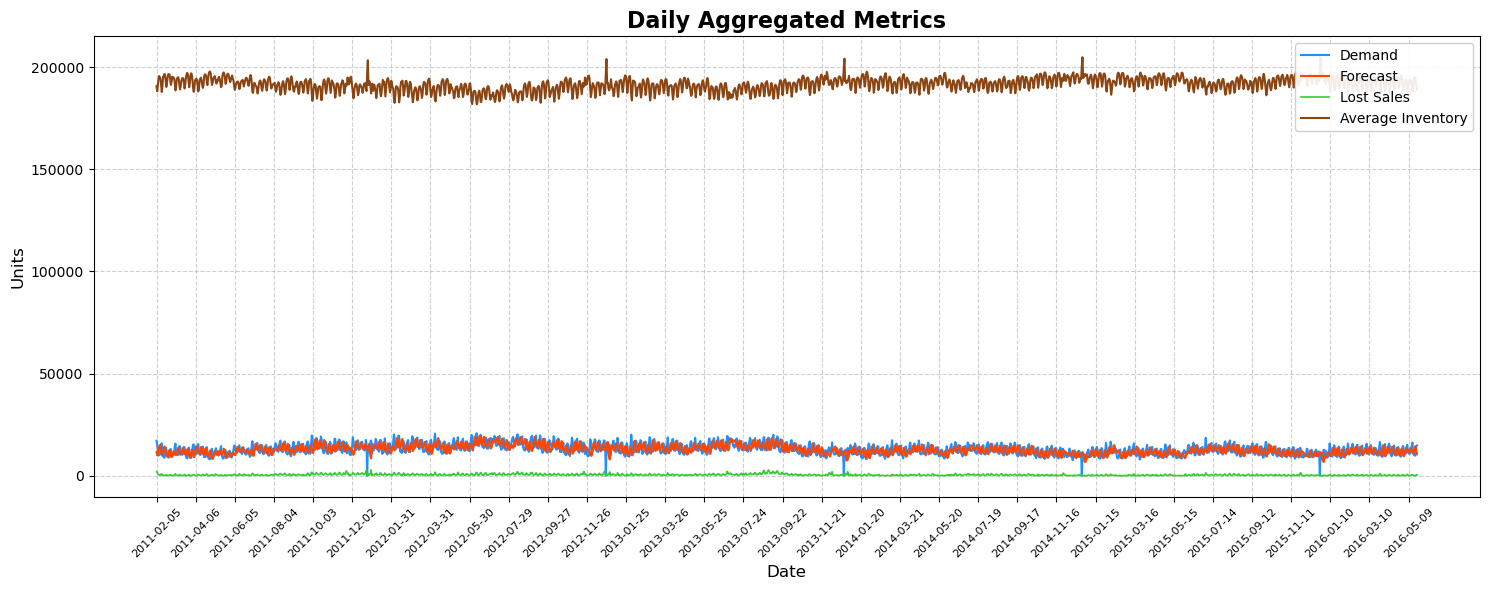

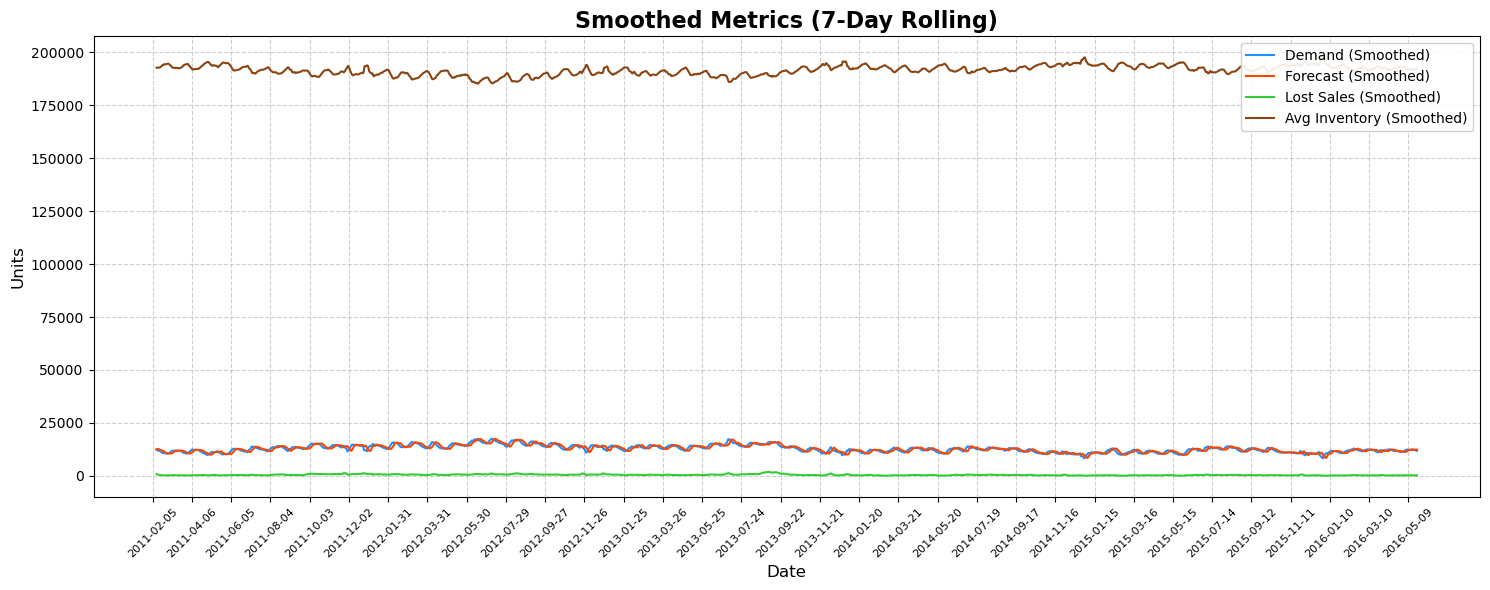

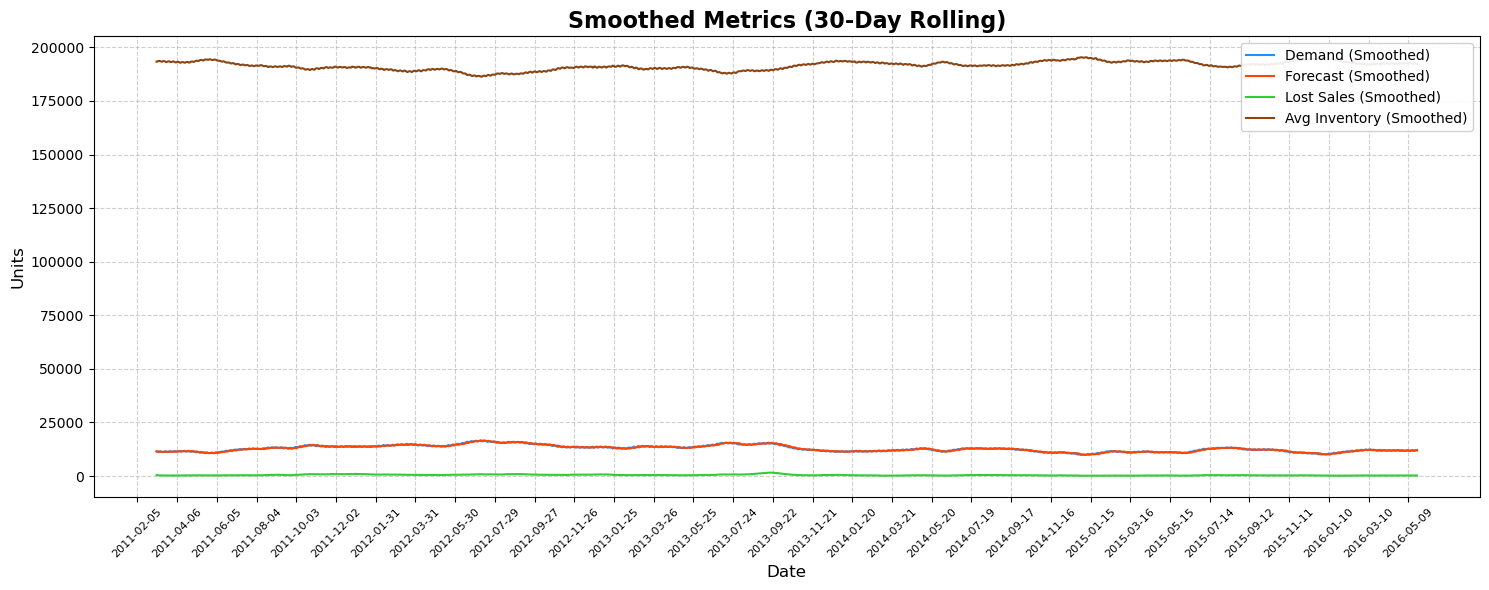

Fill rate: 96.19%
Average inventory: 191351.0
Average proportion of products not in stock: 0.75%


(0.9619471955297704, 191351.0, 0.007516743946419371)

In [62]:
# (R,S) static: Up to level= Fixed S, Safety stock = 0, Variable S
pipeline(demand_matrix=demand_matrix,
        forecast_func=FC_avg_n_days, fc_factor= 3,                                     #forecast
         up_to_level_func=up_to_level_fixed_X, X=35,                      #up to level
         compute_stock_func=compute_stock, order_rate=1, plot=True)                    #compute stock

Fill rate: 89.51%
Average inventory: 308292.0
Average proportion of products not in stock: 1.43%
Fill rate: 92.30%
Average inventory: 396728.0
Average proportion of products not in stock: 0.93%
Fill rate: 94.18%
Average inventory: 485631.0
Average proportion of products not in stock: 0.64%
Fill rate: 95.50%
Average inventory: 574830.0
Average proportion of products not in stock: 0.46%
Fill rate: 96.44%
Average inventory: 664222.0
Average proportion of products not in stock: 0.35%
Fill rate: 97.14%
Average inventory: 753738.0
Average proportion of products not in stock: 0.28%
Fill rate: 97.37%
Average inventory: 789571.0
Average proportion of products not in stock: 0.26%
Fill rate: 97.66%
Average inventory: 843347.0
Average proportion of products not in stock: 0.23%
Fill rate: 97.84%
Average inventory: 879210.0
Average proportion of products not in stock: 0.21%
Fill rate: 98.07%
Average inventory: 933022.0
Average proportion of products not in stock: 0.19%


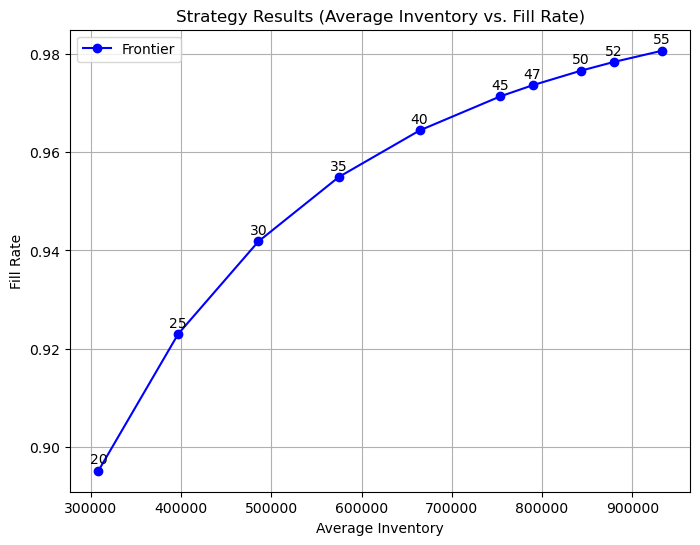

In [63]:
Xs = [20, 25, 30, 35, 40, 45, 47, 50, 52, 55]
policy_results = compute_pareto(
    _demand_matrix=demand_matrix,
    _forecast_func=FC_avg_n_days, _fc_factor=3,
    _up_to_level_func=up_to_level_fixed_X, _X=Xs,
    _compute_stock_func=compute_stock, _order_rate=7
)
#results['static (R,S)'] = policy_results
plot_pareto(policy_results)


## (R,S) dynamic: Up to level= 3 days forecast, Safety stock= X*4th day of fc, Variable X

In [64]:
# (R,S) dynamic: Up to level= 3 days forecast, Safety stock= X*4th day of fc, Variable X
pipeline(demand_matrix=demand_matrix,
        forecast_func=FC_avg_n_days, fc_factor= 3,                                     #forecast
         ss_func=SS_on_forecast, ss_factor=0.75,                             #safety stock
         up_to_level_func=up_to_level_on_forecast,                          #up to level
         compute_stock_func=compute_stock, order_rate=7, plot=False)                    #compute stock

Fill rate: 94.77%
Average inventory: 74539.0
Average proportion of products not in stock: 4.74%


(0.9476851999114836, 74539.0, 0.047436630602782075)

Fill rate: 92.35%
Average inventory: 67752.0
Average proportion of products not in stock: 6.90%
Fill rate: 93.13%
Average inventory: 69617.0
Average proportion of products not in stock: 6.21%
Fill rate: 93.78%
Average inventory: 71378.0
Average proportion of products not in stock: 5.63%
Fill rate: 94.07%
Average inventory: 72224.0
Average proportion of products not in stock: 5.38%
Fill rate: 94.77%
Average inventory: 74539.0
Average proportion of products not in stock: 4.74%
Fill rate: 95.34%
Average inventory: 76773.0
Average proportion of products not in stock: 4.22%
Fill rate: 95.88%
Average inventory: 79315.0
Average proportion of products not in stock: 3.69%
Fill rate: 96.31%
Average inventory: 81725.0
Average proportion of products not in stock: 3.28%
Fill rate: 96.99%
Average inventory: 86753.0
Average proportion of products not in stock: 2.62%
Fill rate: 97.87%
Average inventory: 97409.0
Average proportion of products not in stock: 1.77%
Fill rate: 98.66%
Average inventory: 119

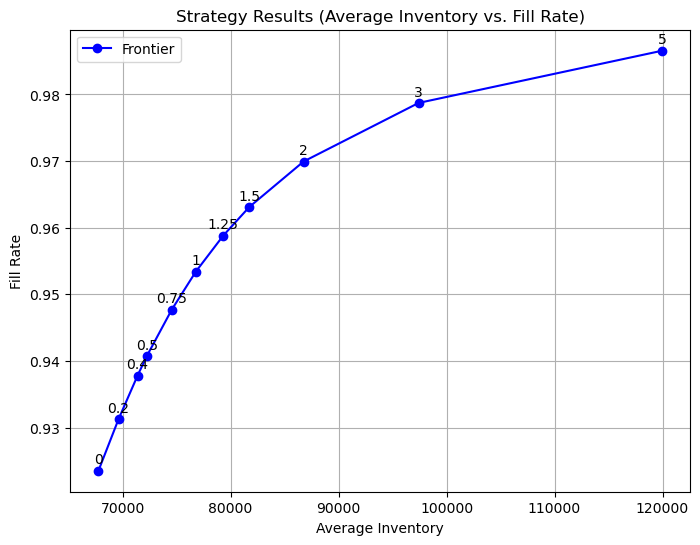

In [65]:
ss_factors = [0, 0.2, 0.4, 0.5, 0.75, 1, 1.25, 1.5, 2, 3, 5]
policy_results = compute_pareto(
    _demand_matrix=demand_matrix,
    _forecast_func=FC_avg_n_days, _fc_factor=3,
    _ss_func = SS_on_forecast, _ss_factor=ss_factors,
    _up_to_level_func=up_to_level_on_forecast,
    _compute_stock_func=compute_stock, _order_rate=7
)
#results['dynamic'] = policy_results
plot_pareto(policy_results)

## Theoretical CSL: Up to level= Normal demand, Safety stock= x*sigma, Variable CSL (x=1.64 for 95% CSL)

/tmp/ipykernel_435978/375110717.py:13: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_means = demand_matrix.rolling(
/tmp/ipykernel_435978/375110717.py:16: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_stds = demand_matrix.rolling(
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


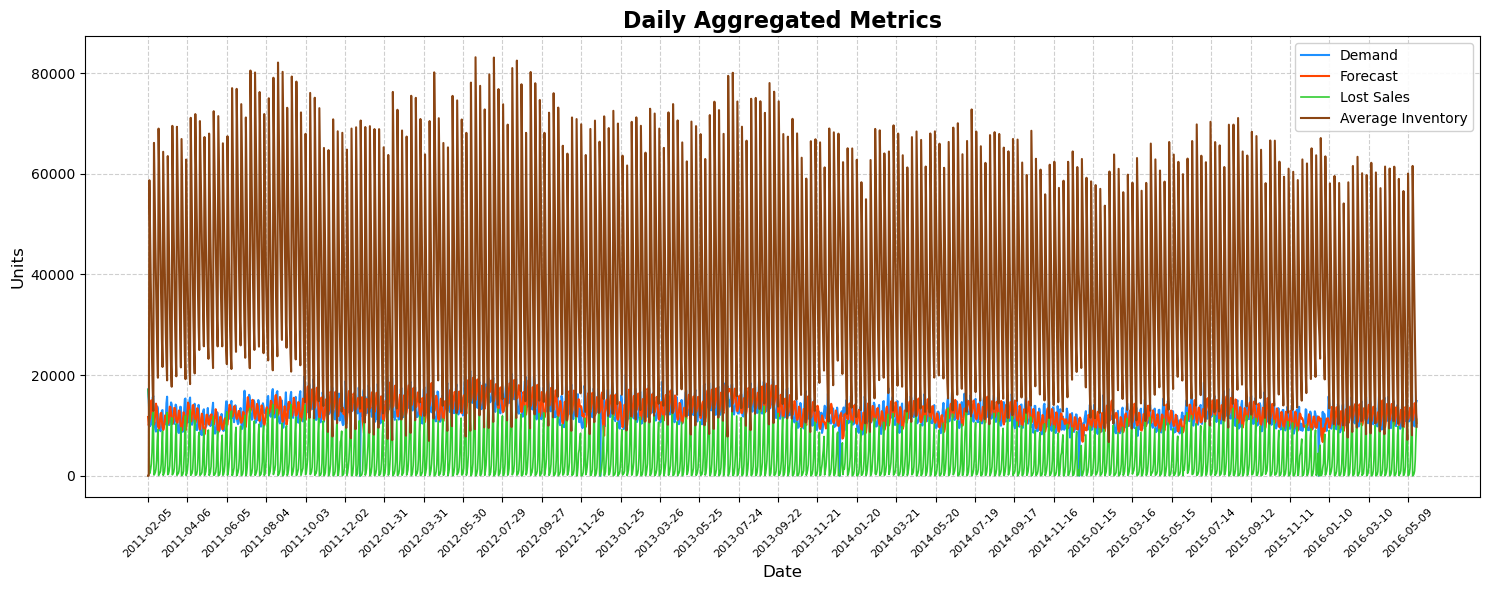

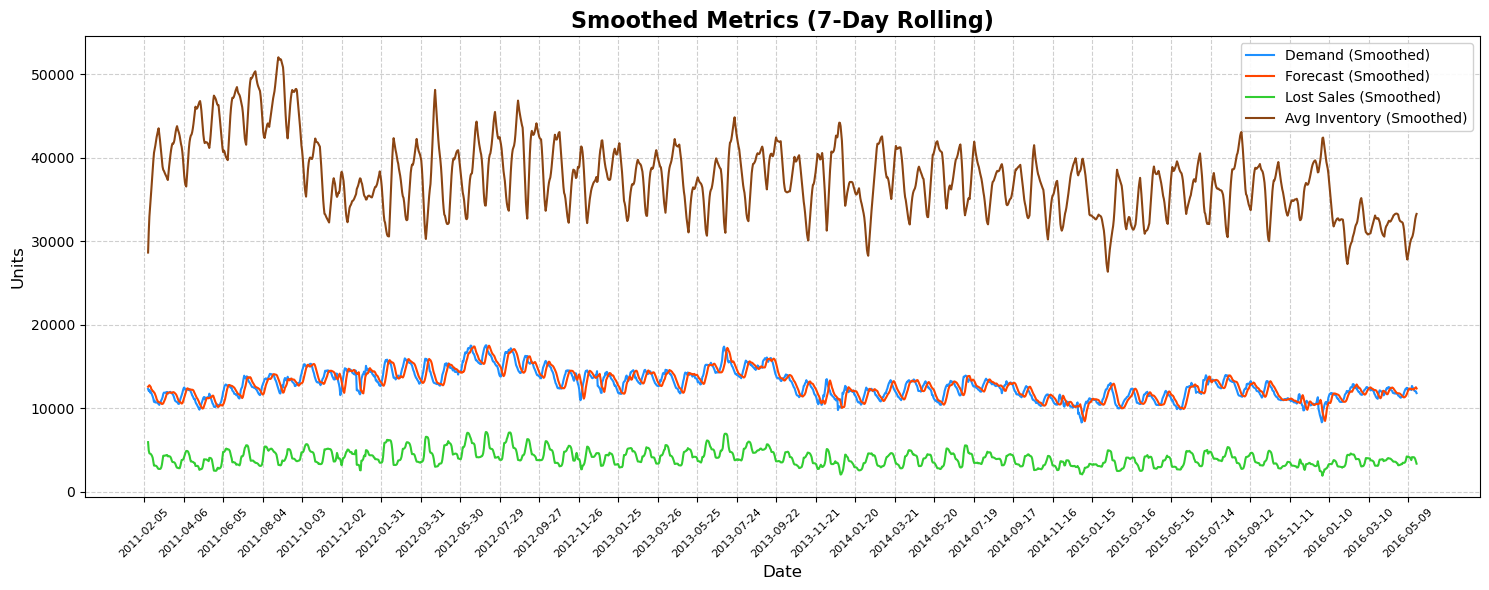

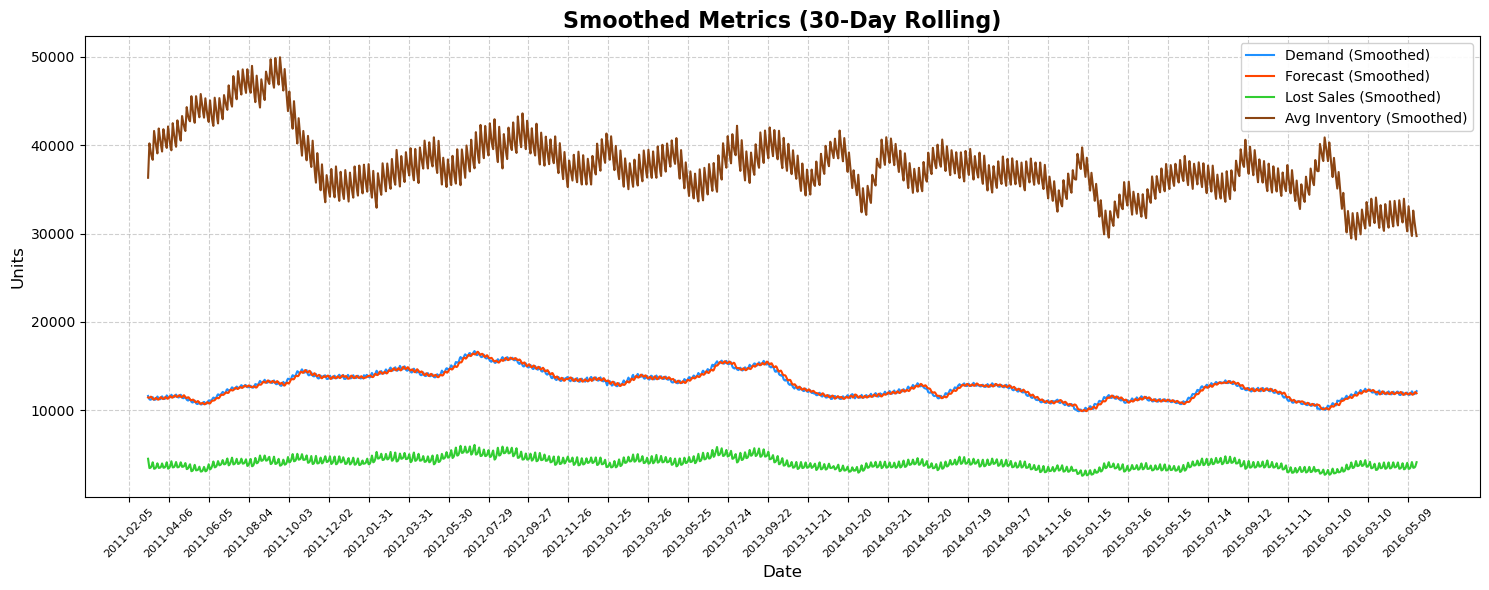

Fill rate: 68.22%
Average inventory: 37455.0
Average proportion of products not in stock: 21.99%


(0.6822206480425108, 37455.0, 0.21985935085007727)

In [70]:
# Theoretical CSL: Up to level= Normal demand, Safety stock= x*sigma, Variable CSL (x=1.64 for 95% CSL)
pipeline(demand_matrix=demand_matrix,
        forecast_func=FC_avg_n_days, fc_factor=3,                                       #forecast
         up_to_level_func=up_to_level_normal_demand, min_fill_rate=0.95,                #up to level
         compute_stock_func=compute_stock, order_rate=7, plot=True)                     #compute stock

/tmp/ipykernel_435978/1479513211.py:49: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_means = demand_matrix.rolling(
/tmp/ipykernel_435978/1479513211.py:52: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_stds = demand_matrix.rolling(
/home/onyx/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


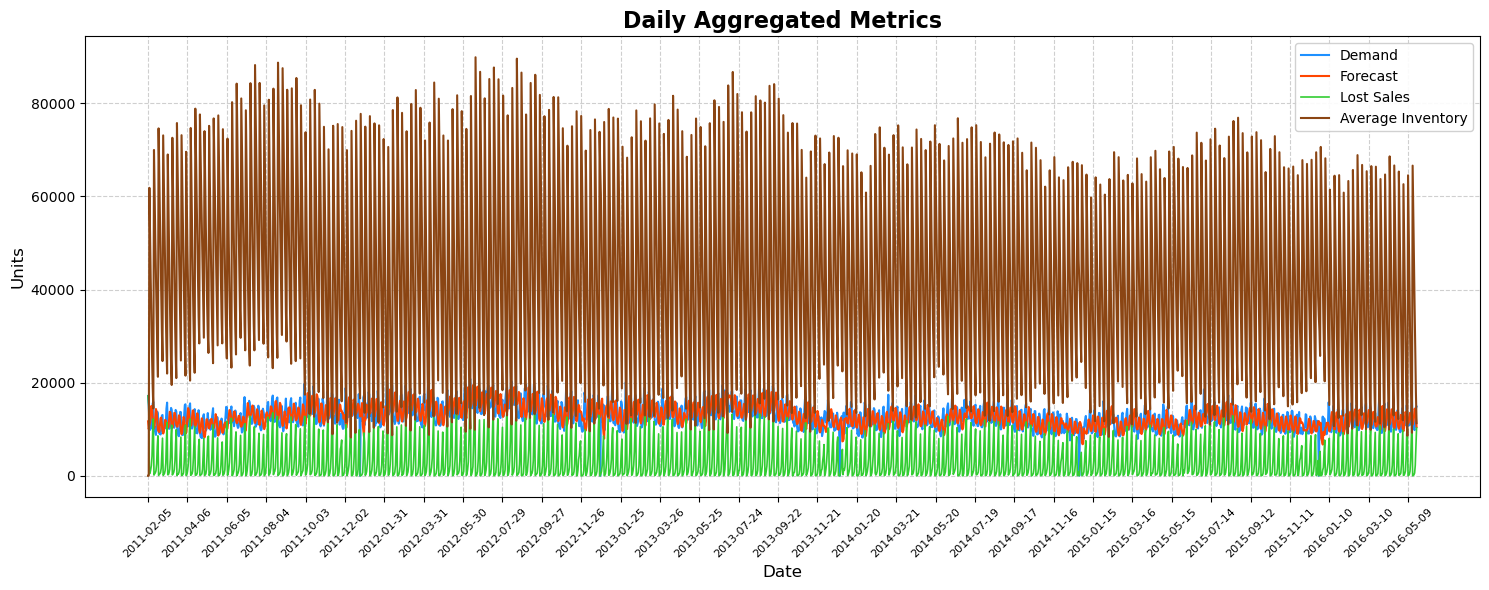

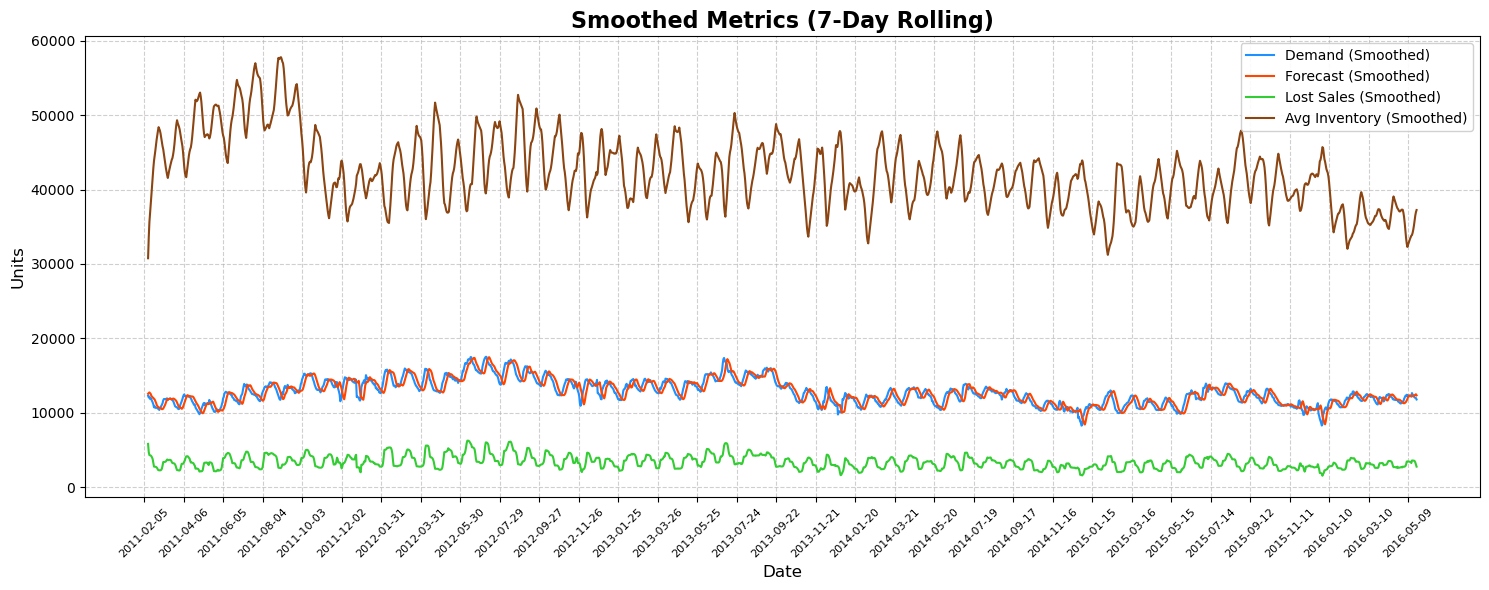

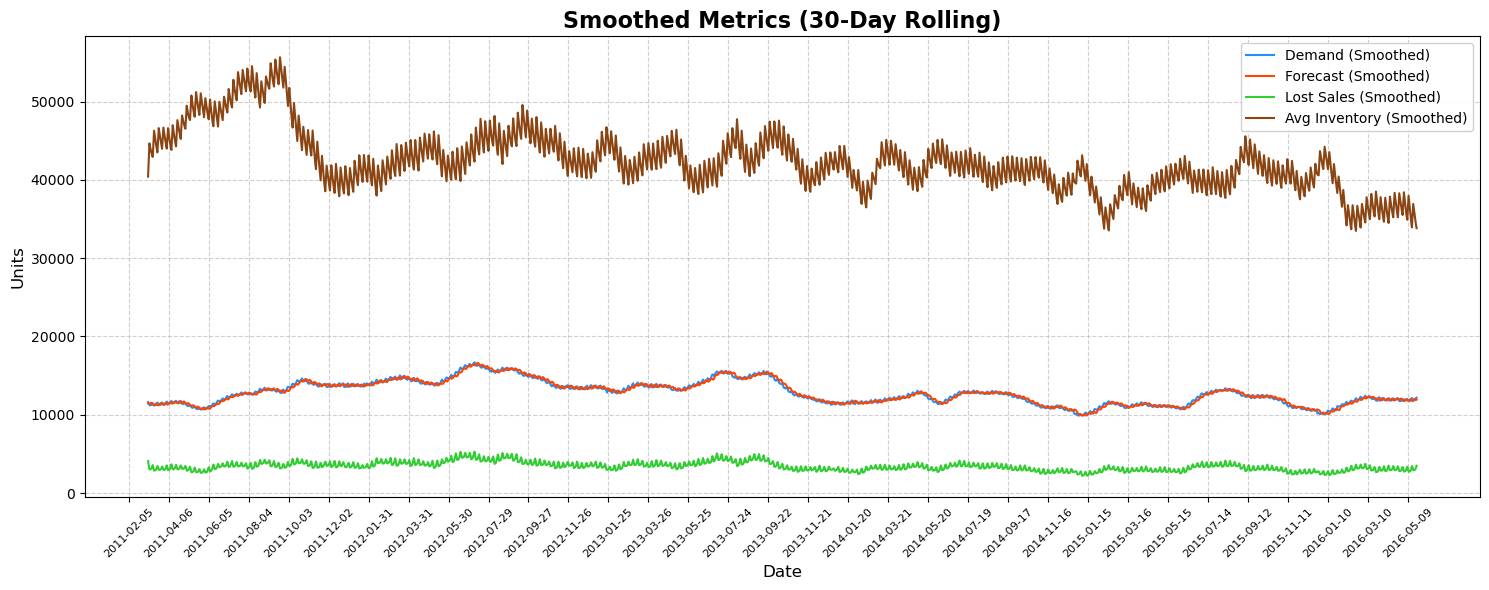

Fill rate: 73.14%
Average inventory: 42106.0
Average proportion of products not in stock: 18.06%


(0.7313550111344926, 42106.0, 0.18055074703760948)

In [74]:
# Theoretical CSL: Up to level= Lognormal demand, Safety stock= x*sigma, Variable CSL (x=1.64 for 95% CSL)
pipeline(demand_matrix=demand_matrix,
        forecast_func=FC_avg_n_days, fc_factor=3,                                       #forecast
         up_to_level_func=up_to_level_lognormal_demand, min_fill_rate=0.95,    #up to level
         compute_stock_func=compute_stock, order_rate=7, plot=True)                     #compute stock

/tmp/ipykernel_435978/1479513211.py:13: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_means = demand_matrix.rolling(
/tmp/ipykernel_435978/1479513211.py:16: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_stds = demand_matrix.rolling(
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 41.39%
Average inventory: 13634.0
Average proportion of products not in stock: 46.94%


/tmp/ipykernel_435978/1479513211.py:13: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_means = demand_matrix.rolling(
/tmp/ipykernel_435978/1479513211.py:16: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_stds = demand_matrix.rolling(
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 51.33%
Average inventory: 20413.0
Average proportion of products not in stock: 37.08%


/tmp/ipykernel_435978/1479513211.py:13: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_means = demand_matrix.rolling(
/tmp/ipykernel_435978/1479513211.py:16: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_stds = demand_matrix.rolling(
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 56.71%
Average inventory: 24922.0
Average proportion of products not in stock: 32.08%


/tmp/ipykernel_435978/1479513211.py:13: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_means = demand_matrix.rolling(
/tmp/ipykernel_435978/1479513211.py:16: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_stds = demand_matrix.rolling(
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 63.39%
Average inventory: 31608.0
Average proportion of products not in stock: 26.13%


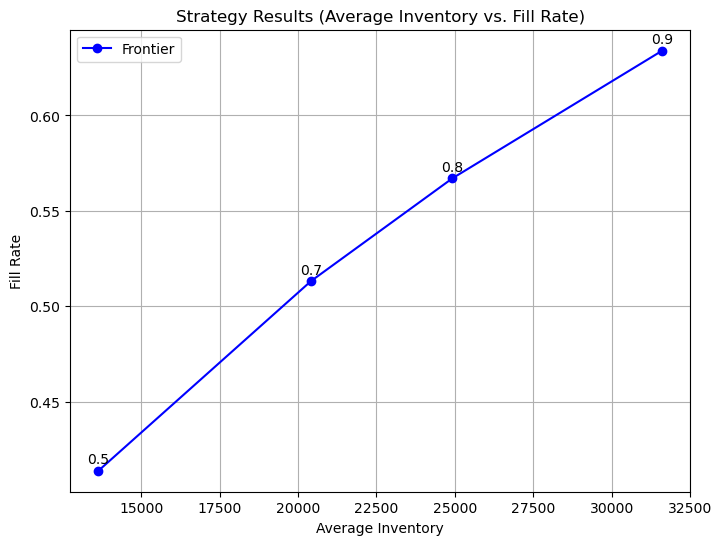

In [79]:
CSLs = [0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 0.97, 0.995, 0.999, 0.9999]
CSLs = CSLs[:4]  # Limiter pour la démonstration
policy_results = compute_pareto(
    _demand_matrix=demand_matrix,
    _forecast_func=FC_avg_n_days, _fc_factor=3,
    _up_to_level_func=up_to_level_normal_demand, _min_fill_rate=CSLs,
    _compute_stock_func=compute_stock, _order_rate=7
)
#results['theoretical'] = policy_results
plot_pareto(policy_results)

/tmp/ipykernel_435978/1479513211.py:13: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_means = demand_matrix.rolling(
/tmp/ipykernel_435978/1479513211.py:16: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_stds = demand_matrix.rolling(
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 90.76%
Average inventory: 26626.0
Average proportion of products not in stock: 12.62%


/tmp/ipykernel_435978/1479513211.py:13: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_means = demand_matrix.rolling(
/tmp/ipykernel_435978/1479513211.py:16: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_stds = demand_matrix.rolling(
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 94.95%
Average inventory: 35843.0
Average proportion of products not in stock: 6.40%


/tmp/ipykernel_435978/1479513211.py:13: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_means = demand_matrix.rolling(
/tmp/ipykernel_435978/1479513211.py:16: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_stds = demand_matrix.rolling(
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 96.34%
Average inventory: 41766.0
Average proportion of products not in stock: 4.38%


/tmp/ipykernel_435978/1479513211.py:13: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_means = demand_matrix.rolling(
/tmp/ipykernel_435978/1479513211.py:16: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_stds = demand_matrix.rolling(
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 97.57%
Average inventory: 50527.0
Average proportion of products not in stock: 2.66%


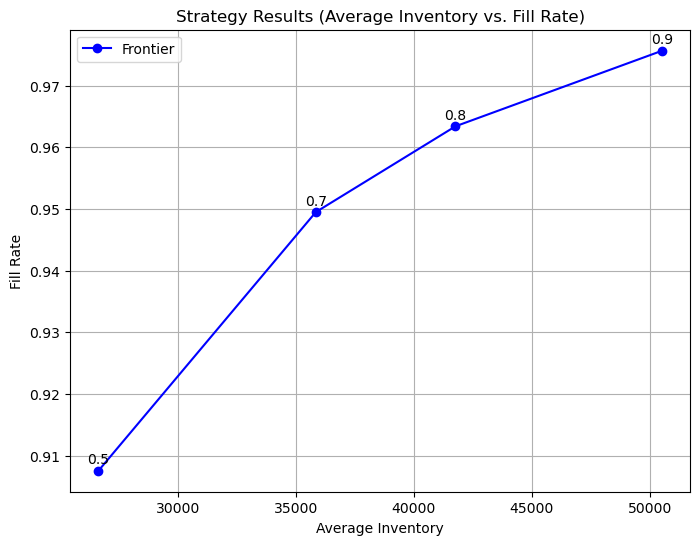

In [80]:
policy_results = compute_pareto(
    _demand_matrix=demand_matrix,
    _forecast_func=FC_avg_n_days, _fc_factor=3,
    _up_to_level_func=up_to_level_normal_demand, _min_fill_rate=CSLs,
    _compute_stock_func=compute_stock, _order_rate=1
)
#results['theoretical'] = policy_results
plot_pareto(policy_results)

## (Q,s)


/tmp/ipykernel_435978/1479513211.py:49: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_means = demand_matrix.rolling(
/tmp/ipykernel_435978/1479513211.py:52: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_stds = demand_matrix.rolling(
/home/onyx/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/tmp/ipykernel_435978/1479513211.py:49: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_means = demand_matrix.rolling(
/tmp/ipykernel_435978/1479513211.py:52: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(

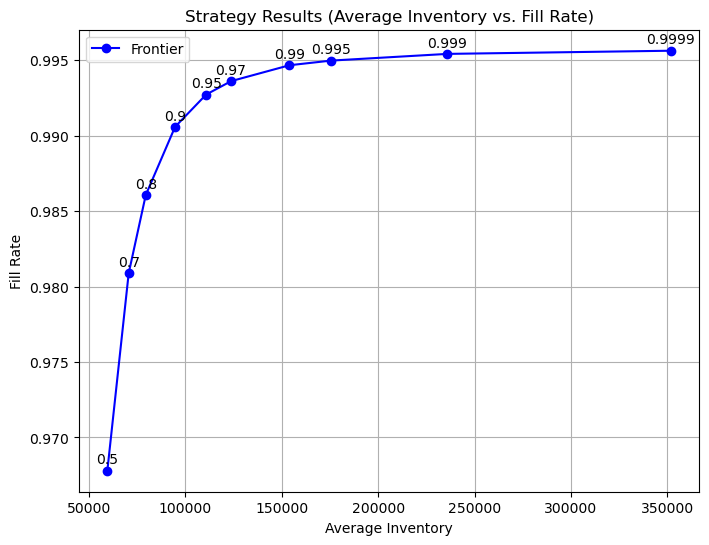

In [81]:
CSLs = [0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 0.97, 0.995, 0.999, 0.9999]
forecast_matrix = FC_avg_n_days(demand_matrix, 3)

policy_results = compute_pareto_Q_s(
    demand_matrix=demand_matrix,
    forecast_matrix=forecast_matrix,
    CSLs=CSLs,
    order_rate=1
)

#results["(Q,s)"] = policy_results
plot_pareto(policy_results)

# Automatic results generation

In [82]:
results = {}

In [24]:
ss_factors = [0, 0.2, 0.4, 0.5, 0.75, 1, 1.25, 1.5, 2, 3]
CSLs = [0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 0.97, 0.995, 0.999, 0.9999]
n_rolling = [3, 7, 14]
n_same = [4, 8]

results['theoretical_CSL'] = compute_pareto(
        _demand_matrix=demand_matrix,
        _forecast_func=FC_avg_n_days, _fc_factor=3,
        _up_to_level_func=up_to_level_normal_demand, _min_fill_rate=CSLs,
        _compute_stock_func=compute_stock
    )
for n in n_rolling:
    results['moving_avg_'+ str(n) +'_dynamic_R_7'] = compute_pareto(
        _demand_matrix=demand_matrix,
        _forecast_func=FC_avg_n_days, _fc_factor=n,
        _ss_func = SS_on_forecast, _ss_factor=ss_factors,
        _up_to_level_func=up_to_level_on_forecast,
        _compute_stock_func=compute_stock
    )
    results['moving_avg_'+ str(n) +'_Q_s'] = compute_pareto_Q_s(
        demand_matrix=demand_matrix,
        forecast_matrix=FC_avg_n_days(demand_matrix, n),
        CSLs=CSLs
    )
for n in n_same:
    results['same_days_avg_'+ str(n) +'_dynamic_R_7'] = compute_pareto(
        _demand_matrix=demand_matrix,
        _forecast_func=FC_avg_n_same_days, _fc_factor=n,
        _ss_func = SS_on_forecast, _ss_factor=ss_factors,
        _up_to_level_func=up_to_level_on_forecast,
        _compute_stock_func=compute_stock
    )
    results['same_days_med_'+ str(n) +'_dynamic_R_7'] = compute_pareto(
        _demand_matrix=demand_matrix,
        _forecast_func=FC_med_n_same_days, _fc_factor=n,
        _ss_func = SS_on_forecast, _ss_factor=ss_factors,
        _up_to_level_func=up_to_level_on_forecast,
        _compute_stock_func=compute_stock
    )
    results['same_days_avg_'+ str(n) +'_Q_s'] = compute_pareto_Q_s(
        demand_matrix=demand_matrix,
        forecast_matrix=FC_avg_n_same_days(demand_matrix, n),
        CSLs=CSLs
    )
    results['same_days_med_'+ str(n) +'_Q_s'] = compute_pareto_Q_s(
        demand_matrix=demand_matrix,
        forecast_matrix=FC_med_n_same_days(demand_matrix, n),
        CSLs=CSLs
    )


/tmp/ipykernel_435978/2956552591.py:14: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_means = demand_matrix.rolling(
/tmp/ipykernel_435978/2956552591.py:17: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_stds = demand_matrix.rolling(
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 96.55%
Average inventory: 68186.0
Average proportion of products not in stock: 4.65%


/tmp/ipykernel_435978/2956552591.py:14: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_means = demand_matrix.rolling(
/tmp/ipykernel_435978/2956552591.py:17: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_stds = demand_matrix.rolling(
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 98.36%
Average inventory: 82835.0
Average proportion of products not in stock: 1.83%


/tmp/ipykernel_435978/2956552591.py:14: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_means = demand_matrix.rolling(
/tmp/ipykernel_435978/2956552591.py:17: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_stds = demand_matrix.rolling(
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 99.00%
Average inventory: 96004.0
Average proportion of products not in stock: 0.94%


/tmp/ipykernel_435978/2956552591.py:14: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_means = demand_matrix.rolling(
/tmp/ipykernel_435978/2956552591.py:17: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_stds = demand_matrix.rolling(
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 99.28%
Average inventory: 108379.0
Average proportion of products not in stock: 0.62%


/tmp/ipykernel_435978/2956552591.py:14: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_means = demand_matrix.rolling(
/tmp/ipykernel_435978/2956552591.py:17: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_stds = demand_matrix.rolling(
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 99.53%
Average inventory: 135485.0
Average proportion of products not in stock: 0.36%


/tmp/ipykernel_435978/2956552591.py:14: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_means = demand_matrix.rolling(
/tmp/ipykernel_435978/2956552591.py:17: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_stds = demand_matrix.rolling(
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 99.60%
Average inventory: 152236.0
Average proportion of products not in stock: 0.30%


/tmp/ipykernel_435978/2956552591.py:14: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_means = demand_matrix.rolling(
/tmp/ipykernel_435978/2956552591.py:17: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_stds = demand_matrix.rolling(
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 99.64%
Average inventory: 176048.0
Average proportion of products not in stock: 0.27%


/tmp/ipykernel_435978/2956552591.py:14: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_means = demand_matrix.rolling(
/tmp/ipykernel_435978/2956552591.py:17: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_stds = demand_matrix.rolling(
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 99.67%
Average inventory: 196210.0
Average proportion of products not in stock: 0.25%


/tmp/ipykernel_435978/2956552591.py:14: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_means = demand_matrix.rolling(
/tmp/ipykernel_435978/2956552591.py:17: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_stds = demand_matrix.rolling(
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 99.69%
Average inventory: 235226.0
Average proportion of products not in stock: 0.24%


/tmp/ipykernel_435978/2956552591.py:14: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_means = demand_matrix.rolling(
/tmp/ipykernel_435978/2956552591.py:17: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_stds = demand_matrix.rolling(
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 99.68%
Average inventory: 209546.0
Average proportion of products not in stock: 0.25%


/tmp/ipykernel_435978/2956552591.py:14: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_means = demand_matrix.rolling(
/tmp/ipykernel_435978/2956552591.py:17: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_stds = demand_matrix.rolling(
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 99.69%
Average inventory: 249883.0
Average proportion of products not in stock: 0.24%


/tmp/ipykernel_435978/2956552591.py:14: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_means = demand_matrix.rolling(
/tmp/ipykernel_435978/2956552591.py:17: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_stds = demand_matrix.rolling(
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 99.70%
Average inventory: 280692.0
Average proportion of products not in stock: 0.23%


/tmp/ipykernel_435978/2956552591.py:14: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_means = demand_matrix.rolling(
/tmp/ipykernel_435978/2956552591.py:17: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_stds = demand_matrix.rolling(
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 99.71%
Average inventory: 319386.0
Average proportion of products not in stock: 0.23%
Fill rate: 87.80%
Average inventory: 27489.0
Average proportion of products not in stock: 14.15%
Fill rate: 89.42%
Average inventory: 29986.0
Average proportion of products not in stock: 12.21%
Fill rate: 90.70%
Average inventory: 32511.0
Average proportion of products not in stock: 10.65%
Fill rate: 91.25%
Average inventory: 33791.0
Average proportion of products not in stock: 9.97%
Fill rate: 92.45%
Average inventory: 37110.0
Average proportion of products not in stock: 8.48%
Fill rate: 93.40%
Average inventory: 40506.0
Average proportion of products not in stock: 7.29%
Fill rate: 94.19%
Average inventory: 44094.0
Average proportion of products not in stock: 6.27%
Fill rate: 94.84%
Average inventory: 47729.0
Average proportion of products not in stock: 5.45%
Fill rate: 95.84%
Average inventory: 55263.0
Average proportion of products not in stock: 4.20%
Fill rate: 97.12%
Average inventory:

In [32]:
results['theoretical_CSL'] = compute_pareto(
        _demand_matrix=demand_matrix,
        _forecast_func=FC_avg_n_days, _fc_factor=3,
        _up_to_level_func=up_to_level_normal_demand, _min_fill_rate=CSLs,
        _compute_stock_func=compute_stock, _order_rate=1
    )

/tmp/ipykernel_435978/2956552591.py:14: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_means = demand_matrix.rolling(
/tmp/ipykernel_435978/2956552591.py:17: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_stds = demand_matrix.rolling(
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 76.66%
Average inventory: 15555.0
Average proportion of products not in stock: 31.49%


/tmp/ipykernel_435978/2956552591.py:14: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_means = demand_matrix.rolling(
/tmp/ipykernel_435978/2956552591.py:17: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_stds = demand_matrix.rolling(
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 83.51%
Average inventory: 19302.0
Average proportion of products not in stock: 22.63%


/tmp/ipykernel_435978/2956552591.py:14: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_means = demand_matrix.rolling(
/tmp/ipykernel_435978/2956552591.py:17: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_stds = demand_matrix.rolling(
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 87.93%
Average inventory: 23024.0
Average proportion of products not in stock: 16.55%


/tmp/ipykernel_435978/2956552591.py:14: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_means = demand_matrix.rolling(
/tmp/ipykernel_435978/2956552591.py:17: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_stds = demand_matrix.rolling(
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 90.76%
Average inventory: 26626.0
Average proportion of products not in stock: 12.62%


/tmp/ipykernel_435978/2956552591.py:14: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_means = demand_matrix.rolling(
/tmp/ipykernel_435978/2956552591.py:17: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_stds = demand_matrix.rolling(
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 94.95%
Average inventory: 35843.0
Average proportion of products not in stock: 6.40%


/tmp/ipykernel_435978/2956552591.py:14: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_means = demand_matrix.rolling(
/tmp/ipykernel_435978/2956552591.py:17: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_stds = demand_matrix.rolling(
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 96.34%
Average inventory: 41766.0
Average proportion of products not in stock: 4.38%


/tmp/ipykernel_435978/2956552591.py:14: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_means = demand_matrix.rolling(
/tmp/ipykernel_435978/2956552591.py:17: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_stds = demand_matrix.rolling(
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 97.57%
Average inventory: 50527.0
Average proportion of products not in stock: 2.66%


/tmp/ipykernel_435978/2956552591.py:14: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_means = demand_matrix.rolling(
/tmp/ipykernel_435978/2956552591.py:17: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_stds = demand_matrix.rolling(
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 98.19%
Average inventory: 58138.0
Average proportion of products not in stock: 1.83%


/tmp/ipykernel_435978/2956552591.py:14: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_means = demand_matrix.rolling(
/tmp/ipykernel_435978/2956552591.py:17: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_stds = demand_matrix.rolling(
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 98.88%
Average inventory: 73346.0
Average proportion of products not in stock: 0.99%


/tmp/ipykernel_435978/2956552591.py:14: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_means = demand_matrix.rolling(
/tmp/ipykernel_435978/2956552591.py:17: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_stds = demand_matrix.rolling(
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 98.49%
Average inventory: 63274.0
Average proportion of products not in stock: 1.46%


/tmp/ipykernel_435978/2956552591.py:14: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_means = demand_matrix.rolling(
/tmp/ipykernel_435978/2956552591.py:17: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_stds = demand_matrix.rolling(
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 99.03%
Average inventory: 79177.0
Average proportion of products not in stock: 0.82%


/tmp/ipykernel_435978/2956552591.py:14: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_means = demand_matrix.rolling(
/tmp/ipykernel_435978/2956552591.py:17: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_stds = demand_matrix.rolling(
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 99.25%
Average inventory: 91617.0
Average proportion of products not in stock: 0.58%


/tmp/ipykernel_435978/2956552591.py:14: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_means = demand_matrix.rolling(
/tmp/ipykernel_435978/2956552591.py:17: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  roll_stds = demand_matrix.rolling(
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/onyx/anaconda3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Fill rate: 99.41%
Average inventory: 107557.0
Average proportion of products not in stock: 0.42%


In [ ]:
results['moving*_avg_30_dynamic'] = compute_pareto(
        _forecast_func=FC_avg_n_days, _fc_factor=30,
        _ss_func = SS_on_forecast, _ss_factor=ss_factors,
        _up_to_level_func=up_to_level_on_forecast,
        _compute_stock_func=compute_stock, _order_rate=7
    )
results['moving*_med_14_dynamic'] = compute_pareto(
        _forecast_func=FC_med_n_days, _fc_factor=14,
        _ss_func = SS_on_forecast, _ss_factor=ss_factors,
        _up_to_level_func=up_to_level_on_forecast,
        _compute_stock_func=compute_stock, _order_rate=7
    )
results['moving*_med_30_dynamic'] = compute_pareto(
        _forecast_func=FC_med_n_days, _fc_factor=30,
        _ss_func = SS_on_forecast, _ss_factor=ss_factors,
        _up_to_level_func=up_to_level_on_forecast,
        _compute_stock_func=compute_stock, _order_rate=7
    )

Fill rate: 88.38%
Average inventory: 68017.0
Average proportion of products not in stock: 9.24%
Fill rate: 89.00%
Average inventory: 70258.0
Average proportion of products not in stock: 8.71%
Fill rate: 89.57%
Average inventory: 72511.0
Average proportion of products not in stock: 8.23%
Fill rate: 89.83%
Average inventory: 73642.0
Average proportion of products not in stock: 8.01%
Fill rate: 90.45%
Average inventory: 76520.0
Average proportion of products not in stock: 7.47%
Fill rate: 91.01%
Average inventory: 79419.0
Average proportion of products not in stock: 6.99%
Fill rate: 91.52%
Average inventory: 82391.0
Average proportion of products not in stock: 6.54%
Fill rate: 91.97%
Average inventory: 85372.0
Average proportion of products not in stock: 6.14%
Fill rate: 92.76%
Average inventory: 91426.0
Average proportion of products not in stock: 5.44%
Fill rate: 93.96%
Average inventory: 103835.0
Average proportion of products not in stock: 4.42%
Fill rate: 84.58%
Average inventory: 61

In [40]:
# Remove entries in `results` whose keys contain 'Q_s' or 'R_7'
keys_to_remove = [key for key in results if 'Q_s' in key and 'R_7' in key]
for key in keys_to_remove:
    results.pop(key)

In [ ]:
print("Number of elements in results:", len(results))

In [34]:
def avg_inventory_at_fill_rate(results_dict, target_fill_rate=0.95):
    """
    Compute the average inventory required for each strategy to achieve the target fill rate,
    but only for strategies where target_fill_rate lies between min and max observed fill_rates.
    """
    inv_required = {}
    for strategy, metrics in results_dict.items():
        avg_invs   = [vals[1] for vals in metrics.values()]
        fill_rates = [vals[0] for vals in metrics.values()]
        fr_min, fr_max = min(fill_rates), max(fill_rates)
        
        # skip if we would have to extrapolate
        if not (fr_min <= target_fill_rate <= fr_max):
            inv_required[strategy] = np.nan
            continue
        
        # fit a line: fill_rate ≃ m * avg_inv + b
        m, b = np.polyfit(avg_invs, fill_rates, 1)
        inv_required[strategy] = np.ceil((target_fill_rate - b) / m)

    return pd.Series(inv_required, name=f"AvgInv@FR{int(target_fill_rate*100)}%") \
             .sort_values()

# example: required average inventory for 90% fill rate, dropping those that don't cover 0.95
required_inv_95 = avg_inventory_at_fill_rate(results, 0.95).dropna()
print(required_inv_95)

moving_avg_7_dynamic           39333.0
moving_avg_3_dynamic           39682.0
moving_avg_14_dynamic          40277.0
same_days_avg_4_dynamic_R_7    44693.0
same_days_avg_4_dynamic        44693.0
moving_avg_14_dynamic_R_7      47730.0
moving_avg_7_dynamic_R_7       49335.0
same_days_avg_8_dynamic_R_7    50662.0
same_days_avg_8_dynamic        50662.0
same_days_med_4_dynamic        51621.0
same_days_med_4_dynamic_R_7    51621.0
moving_avg_3_dynamic_R_7       53281.0
theoretical_CSL                58245.0
moving_avg_3_Q_s               72835.0
moving_avg_7_Q_s               74312.0
moving_avg_14_Q_s              75340.0
same_days_avg_4_Q_s            78805.0
same_days_med_4_Q_s            79269.0
same_days_avg_8_Q_s            84098.0
same_days_med_8_Q_s            88199.0
Name: AvgInv@FR95%, dtype: float64


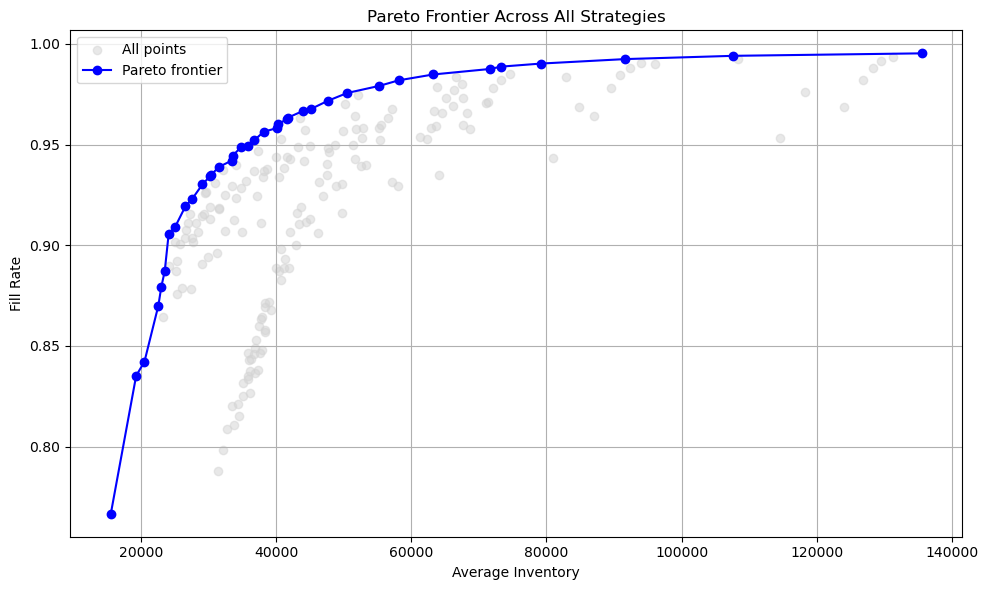

Consecutive Pareto‐front points and their policies:
theoretical_CSL (15555, 0.767) → theoretical_CSL (19302, 0.835)
theoretical_CSL (19302, 0.835) → same_days_med_8_dynamic (20529, 0.842)
same_days_med_8_dynamic (20529, 0.842) → same_days_med_4_dynamic (22581, 0.870)
same_days_med_4_dynamic (22581, 0.870) → theoretical_CSL (23024, 0.879)
theoretical_CSL (23024, 0.879) → same_days_avg_8_dynamic (23530, 0.887)
same_days_avg_8_dynamic (23530, 0.887) → moving_avg_14_dynamic (24114, 0.906)
moving_avg_14_dynamic (24114, 0.906) → moving_avg_7_dynamic (25059, 0.909)
moving_avg_7_dynamic (25059, 0.909) → moving_avg_14_dynamic (26597, 0.919)
moving_avg_14_dynamic (26597, 0.919) → moving_avg_7_dynamic (27629, 0.923)
moving_avg_7_dynamic (27629, 0.923) → moving_avg_14_dynamic (29102, 0.930)
moving_avg_14_dynamic (29102, 0.930) → moving_avg_7_dynamic (30210, 0.934)
moving_avg_7_dynamic (30210, 0.934) → moving_avg_14_dynamic (30362, 0.935)
moving_avg_14_dynamic (30362, 0.935) → moving_avg_7_dynamic 

In [ ]:
# Collect all fill-rate vs avg-inventory points from each policy
records = []
for policy, metrics in results.items():
    for param, (fill_rate, avg_inv, _) in metrics.items():
        records.append({
            'policy': policy,
            'param': param,
            'fill_rate': fill_rate,
            'avg_inventory': avg_inv
        })
df_points = pd.DataFrame(records)

# Identify Pareto-optimal frontier (maximize fill_rate for given avg_inventory)
df_sorted = df_points.sort_values('avg_inventory')
pareto = []
best_fill = -np.inf
for _, row in df_sorted.iterrows():
    if row.fill_rate > best_fill:
        pareto.append(row)
        best_fill = row.fill_rate
pareto_df = pd.DataFrame(pareto)

# Plot all points and the Pareto frontier
plt.figure(figsize=(10, 6))
plt.scatter(df_points['avg_inventory'], df_points['fill_rate'], color='lightgray', alpha=0.5, label='All points')
plt.plot(pareto_df['avg_inventory'], pareto_df['fill_rate'], '-o', color='blue', label='Pareto frontier')

""" # Annotate each segment with the policies at its ends
for i in range(len(pareto_df) - 1):
    p1 = pareto_df.iloc[i]
    p2 = pareto_df.iloc[i + 1]
    xm = (p1['avg_inventory'] + p2['avg_inventory']) / 2
    ym = (p1['fill_rate'] + p2['fill_rate']) / 2
    plt.text(xm, ym,
             f"{p1['policy']} → {p2['policy']}",
             fontsize=8, ha='center') """

plt.xlabel('Average Inventory')
plt.ylabel('Fill Rate')
plt.title('Pareto Frontier Across All Strategies')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Optional: print the consecutive policy transitions
print("Consecutive Pareto‐front points and their policies:")
for i in range(len(pareto_df) - 1):
    p1, p2 = pareto_df.iloc[i], pareto_df.iloc[i+1]
    print(f"{p1['policy']} ({p1['avg_inventory']:.0f}, {p1['fill_rate']:.3f}) → "
          f"{p2['policy']} ({p2['avg_inventory']:.0f}, {p2['fill_rate']:.3f})")

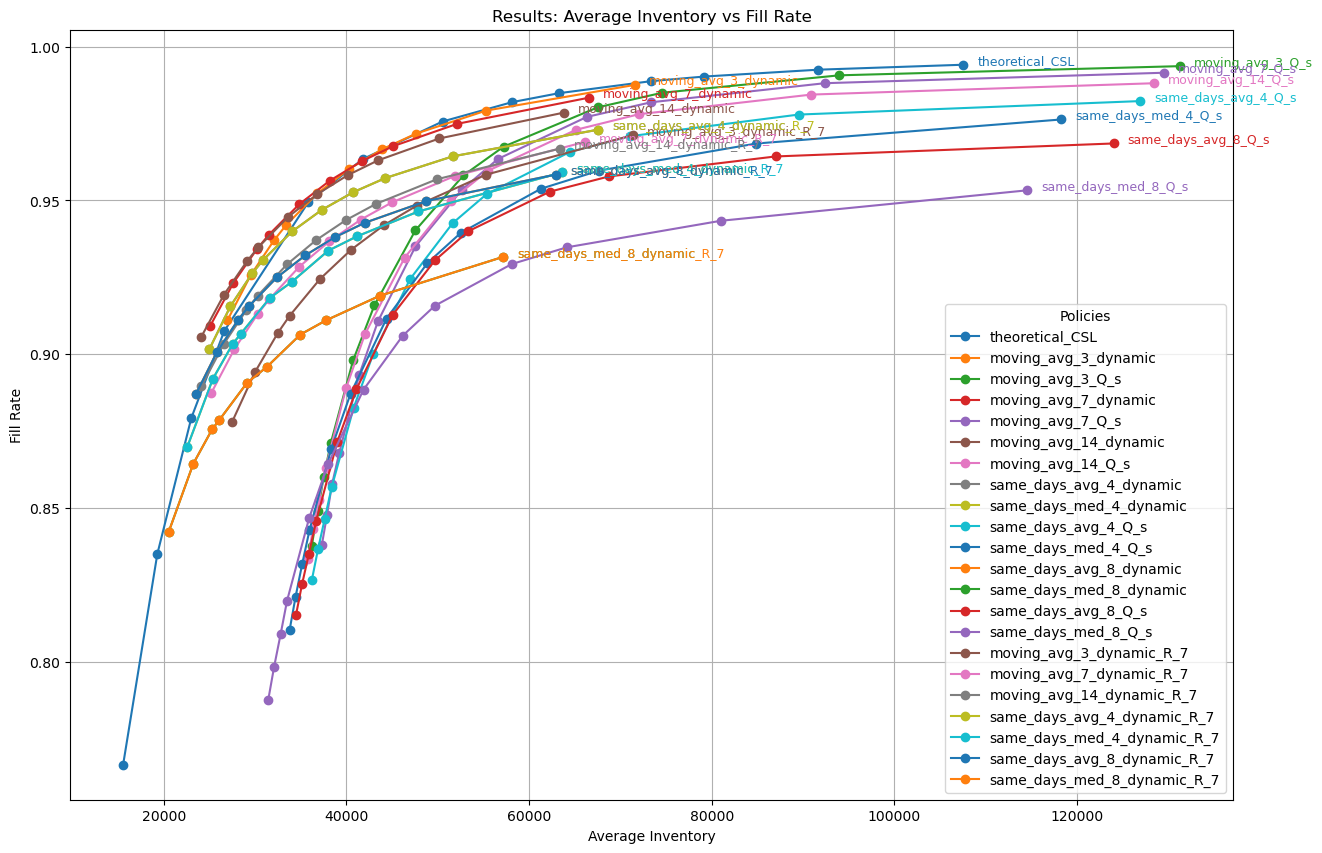

In [33]:
plot_results(results, filter=None)

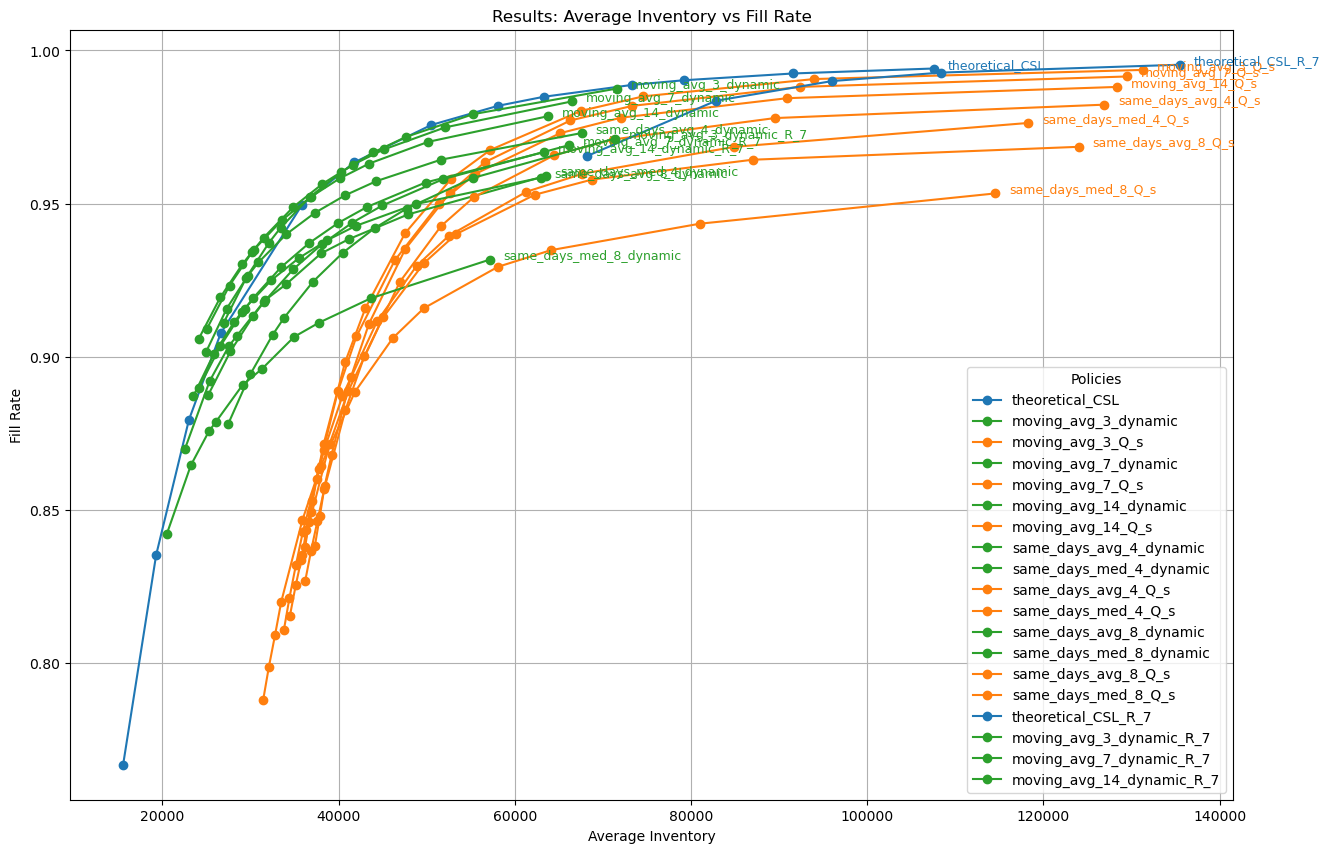

In [ ]:
plot_results(results, filter='policy')

In [ ]:
forecasts = {}
forecasts['FC_avg_3_days'] = FC_avg_n_days(demand_matrix, 3)
forecasts['FC_avg_7_days'] = FC_avg_n_days(demand_matrix, 7)
forecasts['FC_avg_14_days'] = FC_avg_n_days(demand_matrix, 14)
forecasts['FC_avg_4_same_days'] = FC_avg_n_same_days(demand_matrix, 4)
forecasts['FC_avg_8_same_days'] = FC_avg_n_same_days(demand_matrix, 8)
forecasts['FC_med_4_same_days'] = FC_med_n_same_days(demand_matrix, 4)
forecasts['FC_med_8_same_days'] = FC_med_n_same_days(demand_matrix, 8)


kpi_matrix = pd.DataFrame(columns=["RMSPE", "MAPE", "Bias", "sMAPE", "MASE"],)

for name, forecast in forecasts.items():
    kpi_matrix.loc[name] = [
        rmspe(demand_matrix, forecast),
        mape(demand_matrix, forecast),
        bias(demand_matrix, forecast),
        smape(demand_matrix, forecast),
        mase(demand_matrix, forecast, seasonality=7)
    ]
    
print(kpi_matrix)

                         RMSPE       MAPE       Bias      sMAPE  W-MAPE  \
FC_avg_3_days       151.619108  76.880677  32.335210  75.867905     NaN   
FC_avg_7_days       137.307663  70.795351  32.105156  72.099943     NaN   
FC_avg_14_days      134.081397  69.710653  32.590070  71.977368     NaN   
FC_avg_4_same_days  144.905209  73.966426  29.841994  76.254709     NaN   
FC_avg_8_same_days  138.342589  69.848710  29.950824  74.659818     NaN   
FC_med_4_same_days  140.653367  73.877595  20.981151  79.398093     NaN   
FC_med_8_same_days  130.179582  67.430242  16.927649  76.933134     NaN   

                        MASE  
FC_avg_3_days       0.517656  
FC_avg_7_days       0.481024  
FC_avg_14_days      0.479892  
FC_avg_4_same_days  0.504751  
FC_avg_8_same_days  0.494475  
FC_med_4_same_days  0.512557  
FC_med_8_same_days  0.498200  


In [ ]:
def plot_forecasts(demand_matrix, forecasts):
    """Plot every forecast individually against the demand matrix."""
    for fc_name, fc in forecasts.items():
        plt.figure(figsize=(15, 5))
        plt.plot(demand_matrix.iloc[:,100:200].sum(axis=0), label='Demand', color='dodgerblue', linewidth=2)
        plt.plot(fc.iloc[:,100:200].sum(axis=0), label=fc_name, color='limegreen', linewidth=1)
        plt.title("Demand and Forecasts Over Time")
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Units', fontsize=12)
        plt.tick_params(axis='x', labelsize=8)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(loc='upper right', frameon=True, framealpha=0.9)
        # Limiter les xticks pour lisibilité
        xtick_interval = 7  # afficher 1 tick tous les 60 jours
        plt.xticks(ticks=range(0, 100, xtick_interval),
                labels=demand_matrix.iloc[:,100:200].sum(axis=0).index[::xtick_interval], rotation=45)
        plt.tight_layout()
        plt.show()

def plot_group_forecasts(demand_matrix, forecasts):
        """Plot a group of forecasts of the same type against the demand matrix."""
        plt.figure(figsize=(15, 5))
        # Tracés
        plt.plot(demand_matrix.iloc[:,100:200].sum(axis=0), label='Demand', linewidth=2)

        for fc_name, fc in forecasts.items():
                plt.plot(fc.iloc[:,100:200].sum(axis=0), label=fc_name, linewidth=1)

        plt.title("Demand and Forecasts Over Time")
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Units', fontsize=12)

        plt.tick_params(axis='x', labelsize=8)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(loc='upper right', frameon=True, framealpha=0.9)

        # Limiter les xticks pour lisibilité
        xtick_interval = 7  # afficher 1 tick tous les 60 jours
        plt.xticks(ticks=range(0, 100, xtick_interval),
                labels=demand_matrix.iloc[:,100:200].sum(axis=0).index[::xtick_interval], rotation=45)

        plt.tight_layout()
        plt.show()

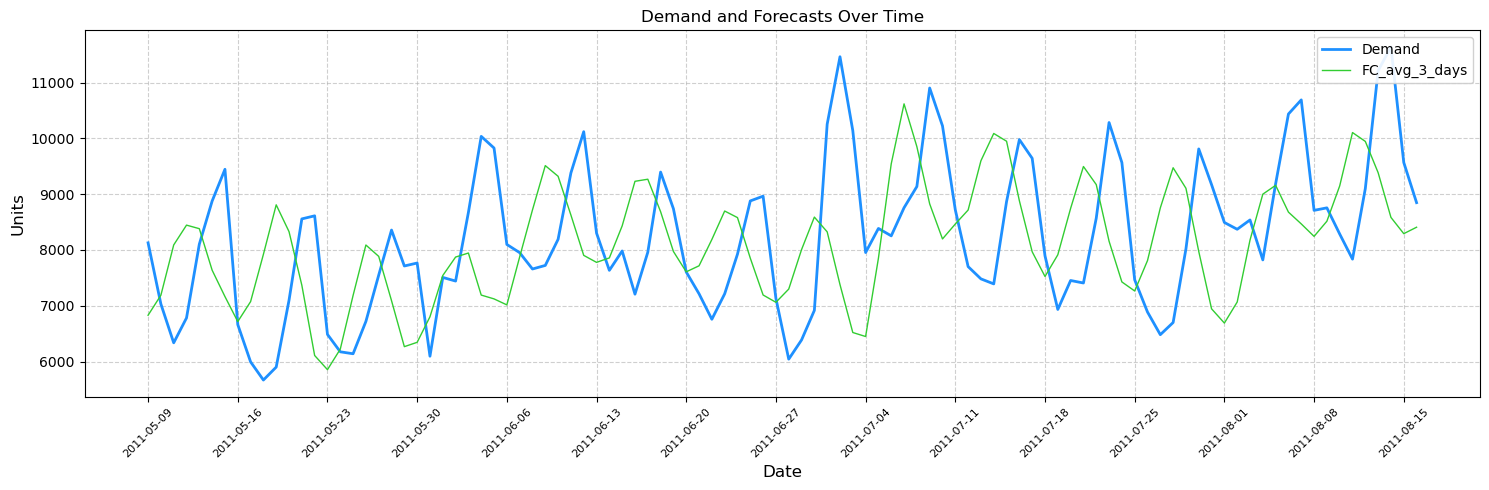

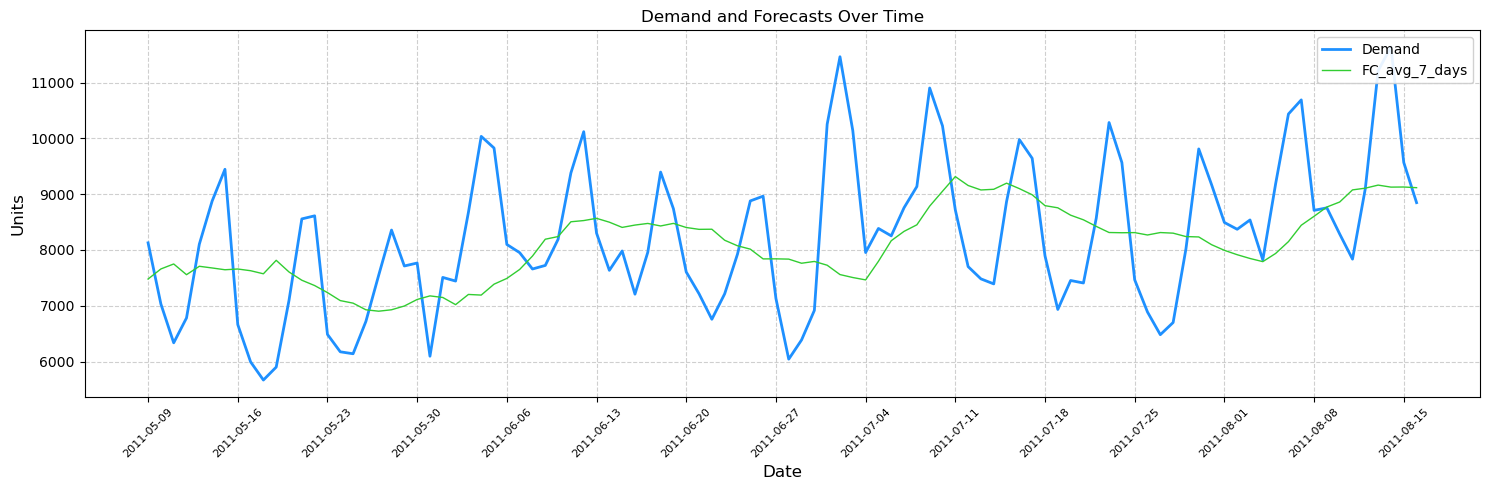

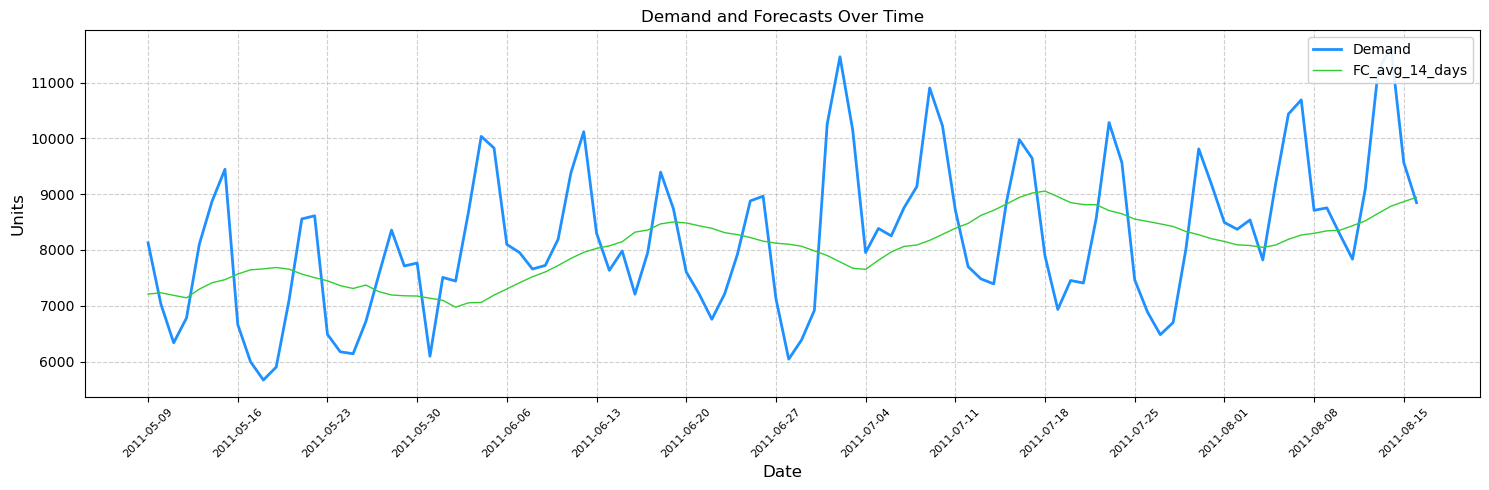

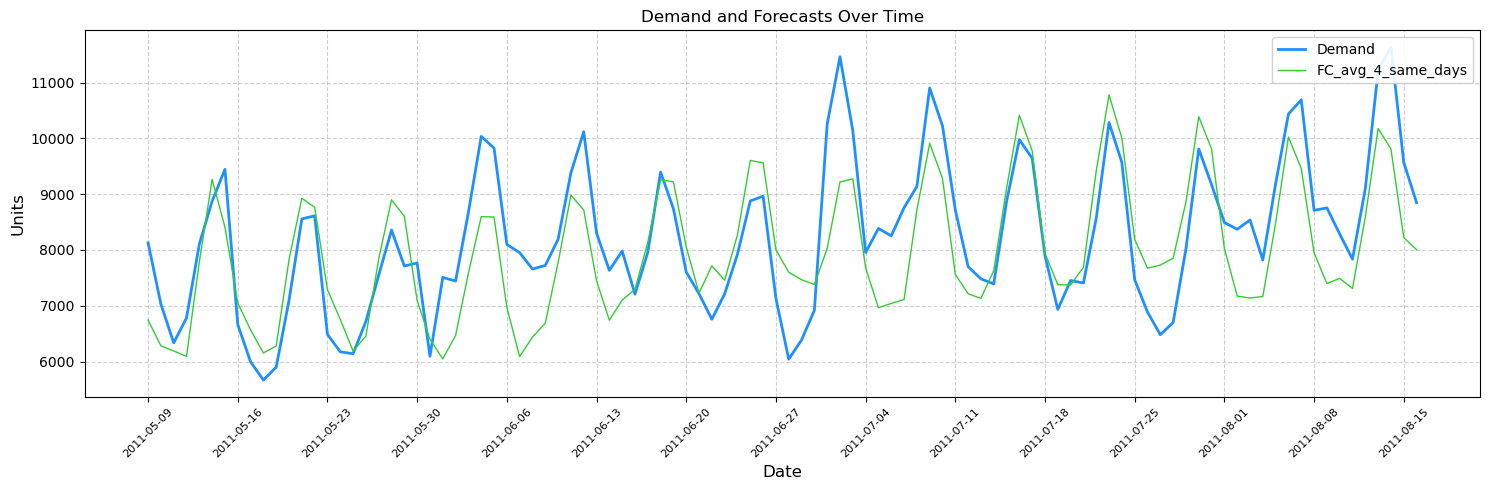

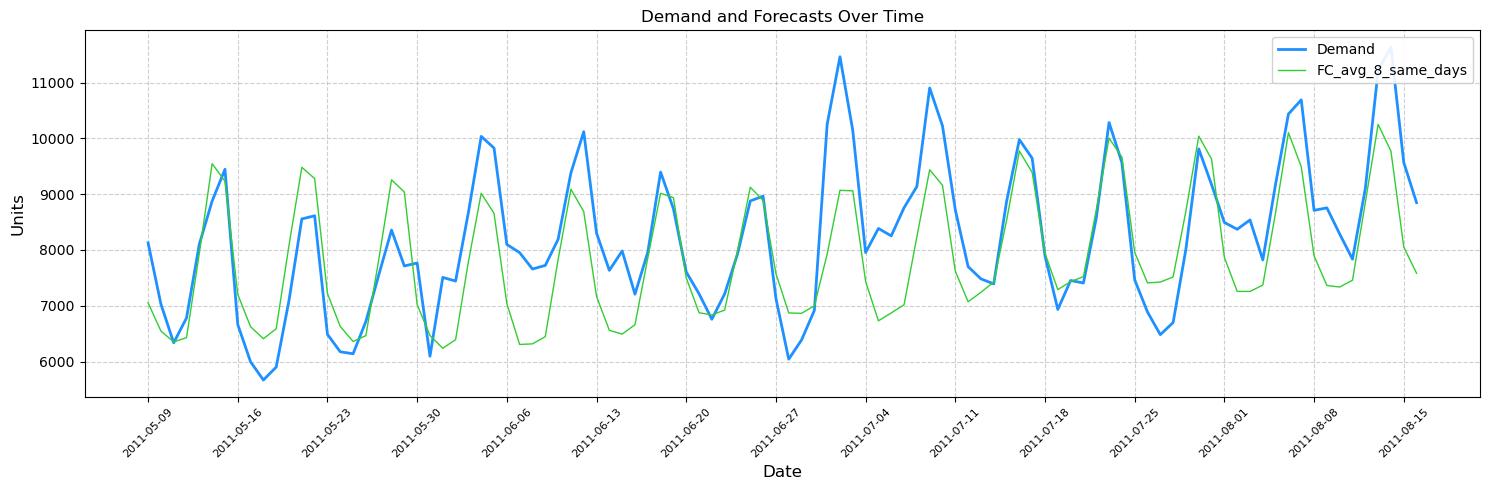

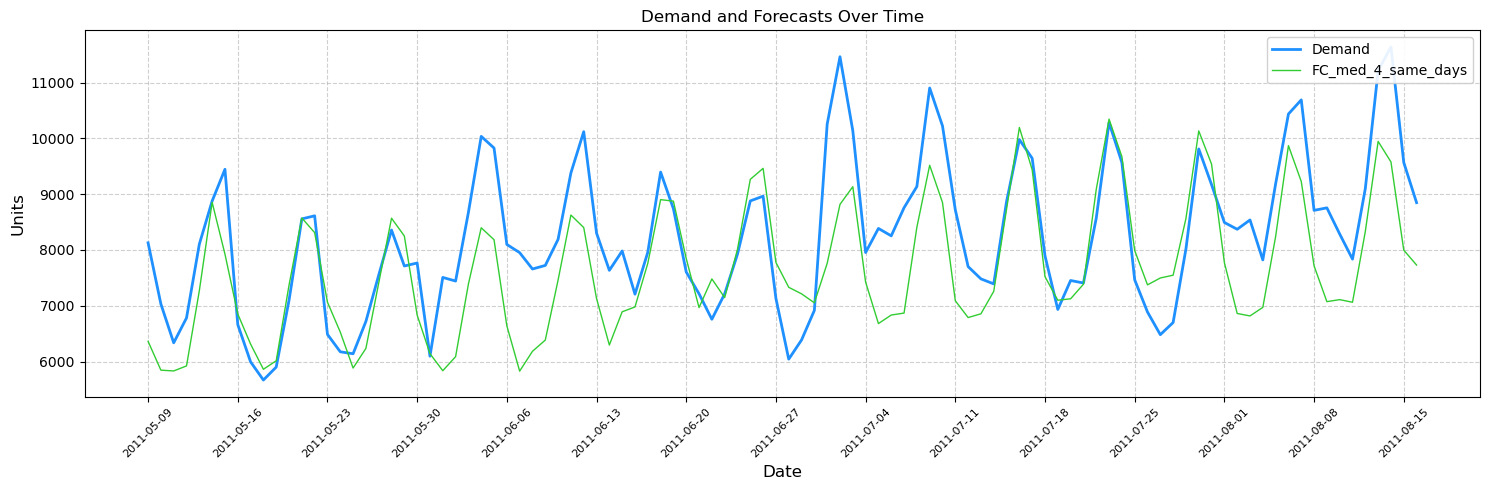

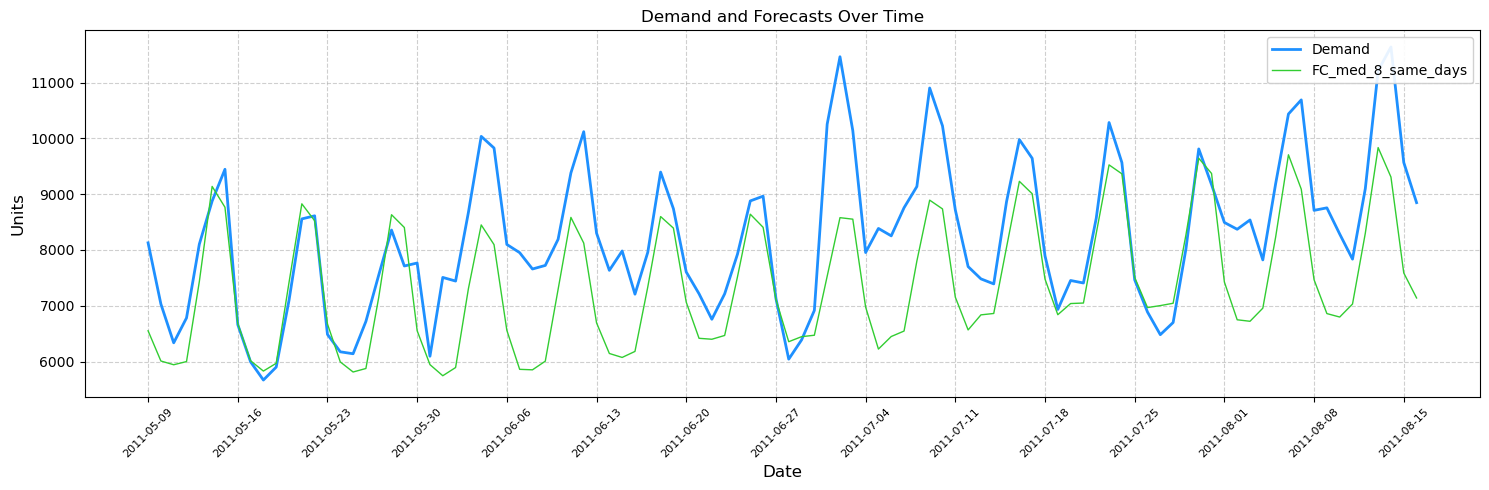

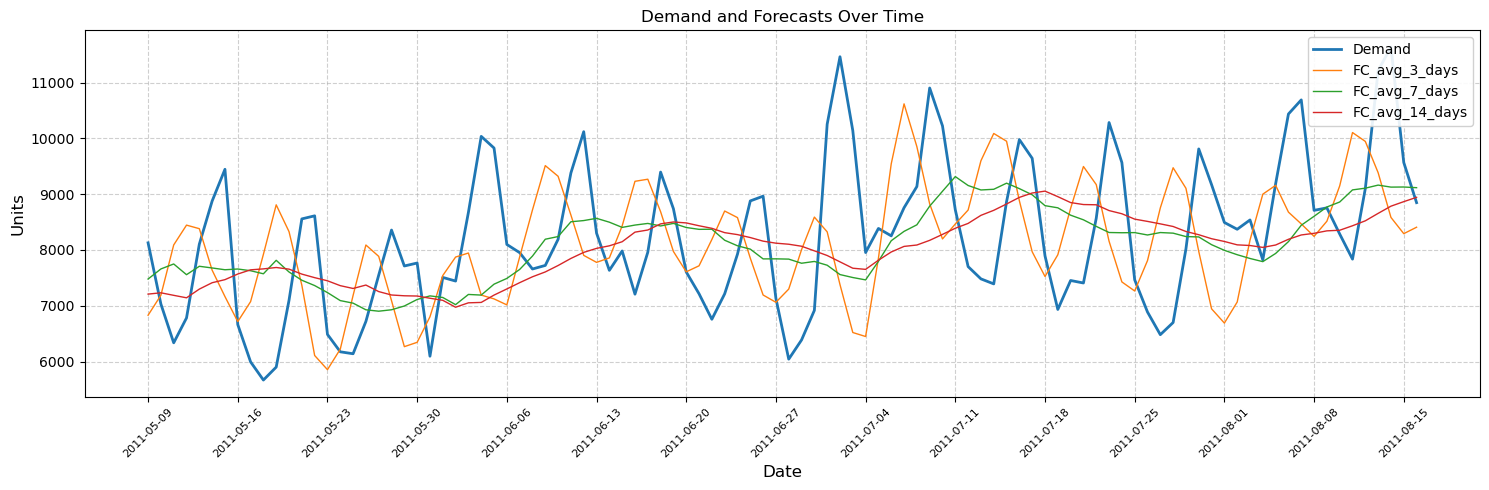

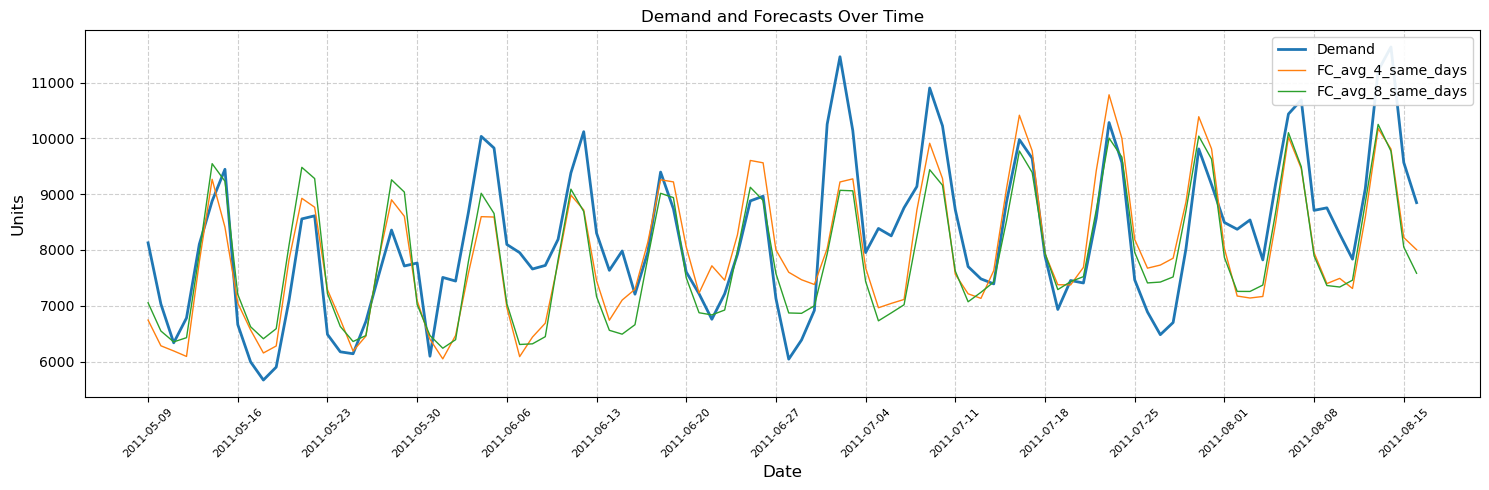

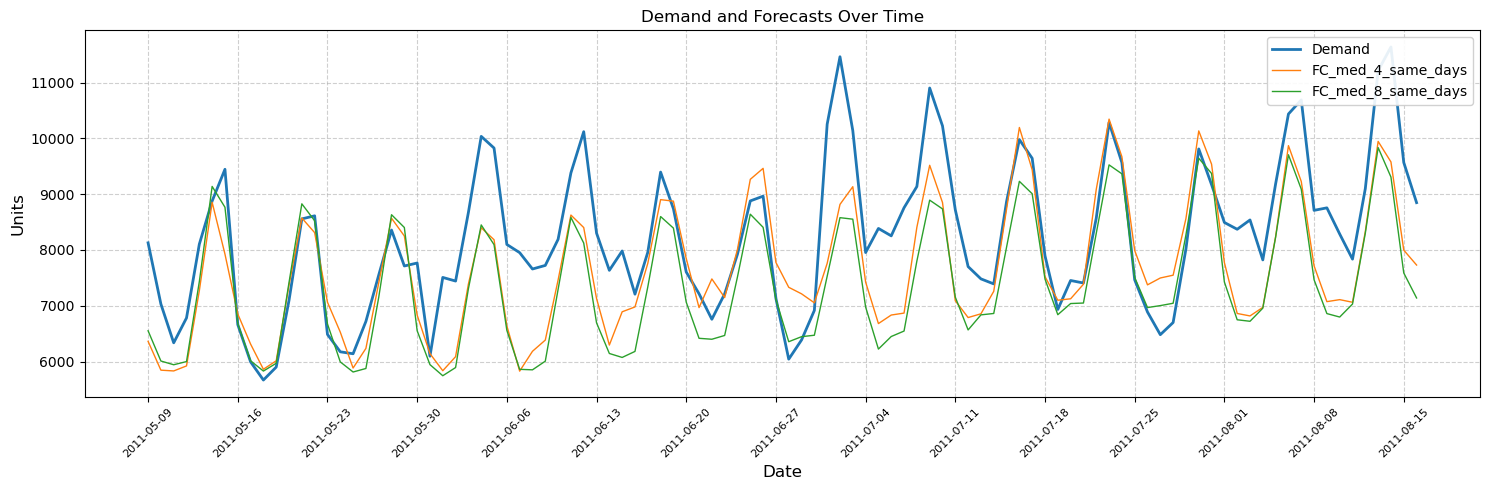

In [ ]:
plot_forecasts(demand_matrix, forecasts)

plot_group_forecasts(demand_matrix, {k: v for k, v in forecasts.items() if ("avg" in k and "same" not in k)})
plot_group_forecasts(demand_matrix, {k: v for k, v in forecasts.items() if ("avg" in k and "same" in k)})
plot_group_forecasts(demand_matrix, {k: v for k, v in forecasts.items() if ("med" in k and "same" in k)})